# Basketball Activity  Recognition

Progetto di Programmazione di Applicazioni Data Intensive aa 2025/2026

E. Pace  
Matricola: 1020123
email: emilia.pace2@studio.unibo.it

## Problema e obiettivi
Lo scopo di questo progetto è lo sviluppo di un modello di activity recognition applicato in un contesto sportivo. Nello specifico si vuole adddestrare un classificatore che distingua tra i 5 gesti atletici del basket, utilizzando i dati provenienti da sensori inerziali (accelerometro e giroscopio) da un dispositivo mobile.

Riferimento Dataset: [Dataset]. (2019). Basketball dataset. UCI Machine Learning Repository. https://doi.org/10.24432/C56G77

#### Descrizione del dataset e dei partecipanti
Per capire meglio i dati che si useranno per l'allenamento del modello andiamo a vedere come sono stati raccolti. Sono stati coinvolti 3 volontar(tutti maschi di età media 22-24 anni) dalla Universidad de los Andes. L'uso di soggetti diversi è fondamentale per assicurarsi che il modello impari a riconoscere il movimento e non le caratteristiche fisiche del singolo individuo.
Hanno collocato i sensori usati per l'aquisizione sul braccio destro dei volontari:

- Accelerometro: misura le accellerazioni lineari lungo gli assi X,Y,Z.
- Giroscopio: Misura la velocità angolare e l'orientamento ($R, \phi, \delta$).
  
Gli utenti poi sono stati istruiti a svolgere le attività seguendo un protocollo specifico a ogni movimento che si voleva studiare per far in modo che si potessero isolare la caratteristiche biomeccaniche di ogni gesto. 

- Hold & Dribble: 3 trial per persona (durata ~5s).
- Pass, Shoot & Pickup: 5 trial per persona (gesti più brevi e impulsivi).
  
Oltre ai trial controllati si è effettuatauna sessione di aquisizione spontanea:
Uno degli utenti ha eseguito le attività in sequenza libera, coordinando le tempistiche tramite l'uso di un cronometro e di riprese video, fornendo un dataset più vicino a uno scenario reale.


### Analisi Esplorativa dei dati

In [6]:
import pandas as pd #Import necessari per l'esplorazione dei dati
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV

In [7]:

label_map = {
    "dribble": 0, "hold": 1, 
    "pass": 2, "pickup": 3, "shoot": 4
}

files = glob.glob("data/*.txt")

Prima di procedere con l'analisi quantitativa è fondamentale comprende la struttura e la provenienza dei dati. Il dataset è organizzato in una serie di file .txt la cui nomenclatura segue una convenzione specifica che sarà utile all'identificazione delle classi e dei soggetti:

- Prefisso: indica l'identità dell'utente che ha eseguito la sessione controllata: d_ per David, jc_ per Juan Carlos, l_ per Leonel. 
- Corpo Centrale: è il nome che identifica l'azione documentata nel file (es shoot, dribble, pass) che sarà il label del nostro modello
- Suffisso: indica il numero del trial oernettebdi di distinguere tra diverse esecuzioni dello stesso gesto.

Una menzione particolare va ai file con prefisso x: questi rappresentano le sessioni di acquisizione spontanea. A differenza dei trial controllati, questi dati riflettono movimenti meno stereotipati e più vicini alla realtà d'uso, rendendoli ideali per la fase di test e validazione della robustezza del modello.

### Significato delle colonne

Ogni file contiene i log grezzi catturati dai sensori inerziali. La struttura interna è organizzata in colonne ognula delle quali rappresenta uno specifico canale informativo:

| Colonna | Unità Di Misura | Descrizione | Sensore |
| :---: | :---: | :----: | :---:|
| Time (s) | Secondi ($\sec$) | Tempo dall'inizio della registrazione | Entrambi |
| X (m/s2) | Metri al secondo quadro | Accellerazione lineare lungo l'asse X| Accelerometro|
| Y (m/s2) | Metri al secondo quadro | Accellerazione lineare lungo l'asse Y| Accelerometro|
| Z (m/s2) | Metri al secondo quadro | Accellerazione lineare lungo l'asse Z| Accelerometro|
| R (m/s2) | Metri al secondo quadro | Modulo dell'accellerazione risultante| Calcolato |
| Theta (deg) | Gradi | Angolo di inclinazione rispetto al piano. | Giroscopio |
| Phi (deg) | Gradi | Angolo di rotazione laterale | Giroscopio |


L'inclusione di entrambi i metri di misura (accelerazione lineare e dati angolari) è essenziale per la classificazione del movimento: studiare l'accelerazione aiuta a catturare l'energia e l'esplosività del gesto (distingue tra fermo e salto), mentre il giroscopio permette di mappare la rotazione del polso e del braccio, cosa che distingue distintivamente un passaggio da un tiro.

In [11]:
dfs_train = []
dfs_test = []

for f in files:
    file_name = os.path.basename(f).lower()
    label = next((v for k, v in label_map.items() if k in file_name), None)
    
    if label is not None:
        with open(f, 'r') as file:
            file.readline() 
            date_line = file.readline().strip() 
        
        df_temp = pd.read_csv(f, skiprows=3, sep=",", engine="python", on_bad_lines="skip")
        df_temp.columns = df_temp.columns.str.strip()
        df_temp["target"] = label
        
        cols_to_check = ['X (m/s2)', 'Y (m/s2)', 'Z (m/s2)', 'R (m/s2)']
        if df_temp['R (m/s2)'].mean() < 2:
            for col in cols_to_check:
                df_temp[col] = df_temp[col] * 9.80665
        
        try:
            dt_obj = pd.to_datetime(date_line, format='%Y-%m-%d %H-%M-%S')
            df_temp["session_dt"] = dt_obj
        except:
            df_temp["session_dt"] = pd.to_datetime("1970-01-01")
            
        if file_name.startswith('x_'):
            dfs_test.append(df_temp)
        else:
            dfs_train.append(df_temp)

df_train = pd.concat(dfs_train, ignore_index=True).dropna()
df_test = pd.concat(dfs_test, ignore_index=True).dropna()

### Caricamento selettivo e labeling automatizzato

Poichè all'interno dei file non c'è un'indicazione che porti al movimento che si sta analizzando è stata implementata una logica di Labeling via Metadata: il sistema estrae il nome dell'attività dal nome del file, garantendo così un'integrità dei dati.

Sono stati inoltre estratti i timestamp di sessione per permettere una tracciabilità cronologica dei trial. Utili in seguito quando attraverso il feature engenieering passeremo da un modello che si allena su isntanti a un modello che si allena per finestre temporali.

In fase di caricamento è stata eseguita anche una prima pulizia: 
- Rimozione nulli: tramite dropna() sono state eliminate tutte le righe corrotte o incomplete.
- Sanitizzazione Header: è stato applicato uno strip ai nomi delle colonne per rimuovere spazzi bianchi che avrebbero impedito l'accesso corretto alle variabili.

#### Strategia di Split: Controllo vs Spontaneità
Analizzando il metodo dell'aquisizione dei dati ho scelto di, invece che fare uno split casuale, di dividere il dataset in base alla natura dell'aquisizione: 

- Training Set: per allenare il modello si useranno i dati dei trial controllati permettendo al modello di imparare i pattern motori distintivi del gesto in condizioni "pure"
- Test Set: composto dai file con prefisso x (aquisizioni spontanee). Questo rappresenterà un test di generalizzazione nel mondo reale. Valutando se il modello addestrato in "laboratorio" con dati puliti è capace di riconoscere gli stesi gesti eseguiti in modo fluido e non predefinito. I file x hanno al loro interno i dati sull'acccelerazione misurati con unità diversa, ovvero $g$, perciò facendo un controllo sulla media (che dovrebbe girare intorno a $9.8 m/s^2$), se è troppo bassa capisco che si sta parlando di $g$ e non di $m/s^2$ e si procede con la conversione

### Validazione dell'Integrità e Preprocessing
Prima di procedere con l'analisi dei dati, è stato implementato un protocollo di pulizia strutturato per garantire la qualità del dataset e la coerenza tra le sessioni di addestramento.

#### Test di Coerenza Fisica
Sebbene il dataset fornisca già il valore della risultante accelerometrica ($R$), è stata verificata per ogni istante temporale la corretta relazione fisica tra le componenti assiali:
$$R = \sqrt{X^2 + Y^2 + Z^2}$$
Il controllo è stato eseguito applicando una soglia minima di tolleranza per gestire eventuali arrotondamenti numerici. L'analisi ha confermato l'integrità dei dati forniti; tuttavia, la funzione di pulizia è stata progettata per eliminare preventivamente ogni riga che presenti discrepanze fisiche (dati corrotti o sensori malfunzionanti).

#### Trimming Deterministico e Pulizia del Segnale
Per isolare il gesto atletico e rimuovere le fasi di stasi o preparazione iniziale, è stata applicata una logica di ritaglio (trimming) basata sul protocollo di acquisizione e sulla classe di riferimento:

- **Classi Dinamiche (0: Dribble, 2: Pass, 3: Pickup):** È stato rimosso sistematicamente l'intervallo temporale $[0, 3]$ secondi. Questa scelta permette di eliminare il tempo di attesa iniziale dell'atleta, garantendo che il modello apprenda solo la porzione dinamica del movimento.
- **Classi Istantanee o di Stasi (1: Hold, 4: Shoot):** Il segnale è stato mantenuto integralmente per preservare la natura specifica del gesto, che in queste categorie può manifestarsi fin dai primi istanti della registrazione.
- **Test Set Esterno (is_x_file):** Per i file relativi alla validazione spontanea, la pulizia temporale è stata disabilitata. Ciò è fondamentale per valutare la robustezza dei modelli su registrazioni "reali" non pre-filtrate, simulando un ambiente di produzione.

In [14]:
def clean_sensor_data(df, tolerance=0.1, is_x_file=False):
    df.columns = df.columns.str.strip()
    initial_rows = len(df)
    
    expected_R = np.sqrt(df['X (m/s2)']**2 + df['Y (m/s2)']**2 + df['Z (m/s2)']**2)
    diff = np.abs(df['R (m/s2)'] - expected_R)
    mask_corrupted = diff > tolerance
    num_corrupted = mask_corrupted.sum()
    
    if num_corrupted > 0:
        df = df[~mask_corrupted].copy()
    
    rows_after_integrity = len(df)
    num_trimmed = 0
    
    if not is_x_file and 'target' in df.columns and 'Time (s)' in df.columns:
        target_val = df['target'].iloc[0]
        
        if target_val in [0, 2, 3]:
            df_final = df[df['Time (s)'] >= 2.5].copy()
            num_trimmed = rows_after_integrity - len(df_final)
            df = df_final
        elif target_val in [1, 4]:
            pass
    
    print(f"Dataset iniziale: {initial_rows}")
    print(f"Righe rimosse (Integrità): {num_corrupted}")
    print(f"Righe rimosse (Trimming): {num_trimmed}")
    print(f"Dataset finale: {len(df)} righe (Totali rimosse: {initial_rows - len(df)})\n")
    
    return df

In [15]:
df_train = clean_sensor_data(df_train)
df_test = clean_sensor_data(df_test, 0.1,  True)

Dataset iniziale: 43426
Righe rimosse (Integrità): 0
Righe rimosse (Trimming): 15990
Dataset finale: 27436 righe (Totali rimosse: 15990)

Dataset iniziale: 9487
Righe rimosse (Integrità): 0
Righe rimosse (Trimming): 0
Dataset finale: 9487 righe (Totali rimosse: 0)



In [16]:
df_train.head(1)

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),target,session_dt
251,2.509824,3.982754,8.808268,-1.284489,9.751811,97.568878,65.669373,0,2019-06-26 17:08:48


In [17]:
df_test.head(1)

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),target,session_dt
0,0.0,2.219863,9.311463,0.448762,9.582931,87.31591,76.590912,0,2019-06-28 13:15:36


In [18]:
df_train.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 27436 entries, 251 to 43425
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time (s)     27436 non-null  float64       
 1   X (m/s2)     27436 non-null  float64       
 2   Y (m/s2)     27436 non-null  float64       
 3   Z (m/s2)     27436 non-null  float64       
 4   R (m/s2)     27436 non-null  float64       
 5   Theta (deg)  27436 non-null  float64       
 6   Phi (deg)    27436 non-null  float64       
 7   target       27436 non-null  int64         
 8   session_dt   27436 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 2.1 MB


In [19]:
df_test.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9487 entries, 0 to 9486
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Time (s)     9487 non-null   float64       
 1   X (m/s2)     9487 non-null   float64       
 2   Y (m/s2)     9487 non-null   float64       
 3   Z (m/s2)     9487 non-null   float64       
 4   R (m/s2)     9487 non-null   float64       
 5   Theta (deg)  9487 non-null   float64       
 6   Phi (deg)    9487 non-null   float64       
 7   target       9487 non-null   int64         
 8   session_dt   9487 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 667.2 KB


In [20]:
df_train.describe()

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),target,session_dt
count,27436.000000,27436.000000,27436.000000,27436.000000,27436.000000,27436.000000,27436.000000,27436.000000,27436
mean,5.644177,3.186929,8.510483,1.408554,10.302359,81.233820,71.916231,1.885442,2019-06-27 01:24:53.336674304
min,2.500001,-39.195477,-10.232818,-33.500866,1.740628,20.755613,0.143037,0.000000,2019-06-26 16:08:40
25%,3.581087,1.490391,7.389704,-0.102951,9.671009,77.290266,58.625720,0.000000,2019-06-26 17:10:24
50%,4.929504,3.186682,8.793304,1.423353,9.882458,81.710018,70.744339,2.000000,2019-06-26 17:29:34
75%,6.930183,5.013458,9.448717,2.199373,10.272254,90.599793,81.017818,3.000000,2019-06-27 16:01:44
max,20.670580,38.540661,39.221813,28.358122,54.321270,170.416168,359.938202,4.000000,2019-06-27 16:11:30
std,2.846636,3.720460,2.563766,2.829496,2.617296,16.057913,29.668107,1.342265,NaN


In [21]:
df_test.describe()

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),target,session_dt
count,9487.000000,9487.000000,9487.000000,9487.000000,9487.000000,9487.000000,9487.000000,9487.000000,9487
mean,3.912190,2.414237,8.856699,1.892993,10.297881,78.863696,78.076232,1.574049,2019-06-28 13:17:30.820596736
min,0.000000,-39.182088,-10.362157,-36.411748,0.729732,9.837831,0.123749,0.000000,2019-06-28 13:14:42
25%,1.584700,0.478074,8.509083,0.712031,9.754557,72.504860,65.879364,0.000000,2019-06-28 13:15:36
50%,3.240572,3.068314,8.778933,1.979325,9.861832,78.124321,71.194672,1.000000,2019-06-28 13:16:51
75%,5.409863,3.867713,9.585500,2.963011,9.975148,85.843621,87.739475,3.000000,2019-06-28 13:19:15
max,12.040571,25.923938,38.844621,20.135543,52.076185,164.814468,359.069855,4.000000,2019-06-28 13:21:02
std,2.962487,3.507716,3.117899,2.442066,3.129513,12.022593,33.348966,1.431319,NaN


## Preparazione dei Dati e Preprocessing
In questa sezione si preapara il training set seguendo un approccio incrementale per valutare l'impatto delle scelte tecniche fatte.

#### Standardizzazione (Scaling)
Tralasciando i modelli che si andranno ad utilizzare, i dati delle dei sensori hanno scale diverse tra l'accellerazione e e gli angoli del giroscopio percio si rende fondamentale la standardizzazione delle variabile in modo che abbiano media 0 e varianza 1. Evitando che variabili con valori numerici molto grandi domino ingiustamente il calcolo dei pesi.

In [23]:
from sklearn.preprocessing import StandardScaler

features = ['X (m/s2)', 'Y (m/s2)', 'Z (m/s2)', 'R (m/s2)', 'Theta (deg)', 'Phi (deg)']

scaler = StandardScaler()

df_train[features] = scaler.fit_transform(df_train[features])

df_test[features] = scaler.transform(df_test[features])

Si utilizza il fit_transform sul training set così il calcolo dei parametri media e deviazione standard non avrà al suo interno le statistiche del test set. 
Invece nel test set si utilizza transform perchè i dati devono essere trattati come il training test, mantenendo la coerenza matematica.

In [25]:
df_train.describe()

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),target,session_dt
count,27436.000000,2.743600e+04,2.743600e+04,2.743600e+04,2.743600e+04,2.743600e+04,2.743600e+04,27436.000000,27436
mean,5.644177,-2.486226e-17,-1.388143e-16,-1.657484e-17,-4.247303e-16,3.066346e-16,4.931015e-16,1.885442,2019-06-27 01:24:53.336674304
min,2.500001,-1.139192e+01,-7.310981e+00,-1.233791e+01,-3.271272e+00,-3.766324e+00,-2.419248e+00,0.000000,2019-06-26 16:08:40
25%,3.581087,-4.560107e-01,-4.371692e-01,-5.342057e-01,-2.412267e-01,-2.455877e-01,-4.479812e-01,0.000000,2019-06-26 17:10:24
50%,4.929504,-6.649186e-05,1.103167e-01,5.230281e-03,-1.604362e-01,2.965558e-02,-3.950079e-02,2.000000,2019-06-26 17:29:34
75%,6.930183,4.909506e-01,3.659660e-01,2.794962e-01,-1.150244e-02,5.832728e-01,3.067858e-01,3.000000,2019-06-27 16:01:44
max,20.670580,9.502691e+00,1.197921e+01,9.524686e+00,1.681877e+01,5.553896e+00,9.708311e+00,4.000000,2019-06-27 16:11:30
std,2.846636,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.000018e+00,1.342265,NaN


In [26]:
df_test.describe()

,Time (s),X (m/s2),Y (m/s2),Z (m/s2),R (m/s2),Theta (deg),Phi (deg),target,session_dt
count,9487.000000,9487.000000,9487.000000,9487.000000,9487.000000,9487.000000,9487.000000,9487.000000,9487
mean,3.912190,-0.207691,0.135044,0.171213,-0.001711,-0.147601,0.207634,1.574049,2019-06-28 13:17:30.820596736
min,0.000000,-11.388321,-7.361431,-13.366689,-3.657515,-4.446237,-2.419898,0.000000,2019-06-28 13:14:42
25%,1.584700,-0.728110,-0.000546,-0.246169,-0.209304,-0.543602,-0.203484,0.000000,2019-06-28 13:15:36
50%,3.240572,-0.031882,0.104711,0.201725,-0.168317,-0.193646,-0.024321,1.000000,2019-06-28 13:16:51
75%,5.409863,0.182987,0.419319,0.549386,-0.125021,0.287079,0.533352,3.000000,2019-06-28 13:19:15
max,12.040571,6.111456,11.832083,6.618610,15.960970,5.205046,9.679042,4.000000,2019-06-28 13:21:02
std,2.962487,0.942835,1.216163,0.863090,1.195726,0.748716,1.124088,1.431319,NaN


Al termine della fase di preprocessing, il dataset si presenta in una forma normalizzata pronta per l'input algoritmico. 
Ogni istante temporale è descritto da un vettore di feature dove:
- Le componenti fisiche dell'accelerometro e del giroscopio sono state ricondotte a una scala comune tramite Standardizzazione, eliminando le discrepanze dovute alle diverse unità di misura ($m/s^2$ vs $deg$).
- La colonna target rappresenta la nostra Ground Truth codificata numericamente.

### Analisi della Distribuzione Standardizzata delle variabili

Il set di grafici illustra la densità di probabilità delle variabili chiave dopo il processo di standardizzazione. La centralità di tutte le distribuzioni sullo **zero** conferma la corretta applicazione dello `StandardScaler` e l'allineamento delle unità di misura tra i diversi dataset.

### Dinamica delle Intensità (R e Z)

In [29]:
def graficoDistribuzioneBox(col, color, name):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)}, 
                                        figsize=(8, 5))
    
    sns.boxplot(x=df_train[col], ax=ax_box, color=color, fliersize=3, linewidth=1.2)
    sns.histplot(df_train[col], ax=ax_hist, kde=True, color=color)
    
    ax_box.set(xlabel='')
    ax_hist.set_title(f'Analisi Statistica: {name}', fontsize=12, fontweight='bold')
    ax_hist.set_xlabel('Valore Standardizzato', fontsize=10)
    ax_hist.set_ylabel('Frequenza', fontsize=10)
    
    plt.tight_layout()
    plt.show()


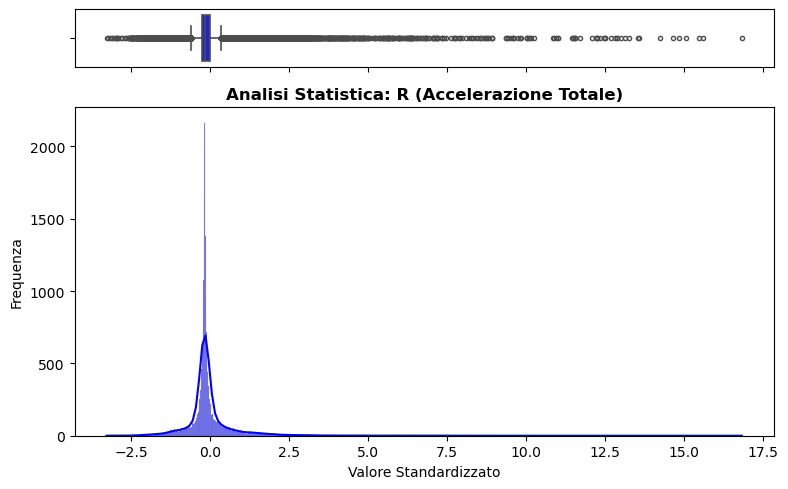

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

col, color, name = ('R (m/s2)', 'blue', 'R (Accelerazione Totale)')
graficoDistribuzioneBox(col, color, name)


- **Accelerazione Risultante (R):**
    - **Significato fisico:** Si osserva una concentrazione massima di dati intorno allo **0**, che nei dati originali corrisponde a circa 9.81 m/s².
    - **Eventi Esplosivi:** La marcata asimmetria a destra (coda che supera il valore 15) identifica i picchi di forza istantanea generati dai gesti tecnici più intensi, come il rilascio della palla o lo stacco da terra.
    - **Ruolo del Box Plot**: La visualizzazione "a scatola" permette di distinguere immediatamente la varianza del movimento normale rispetto ai gesti tecnici atletici, che si manifestano come outlier distanti dalla media.

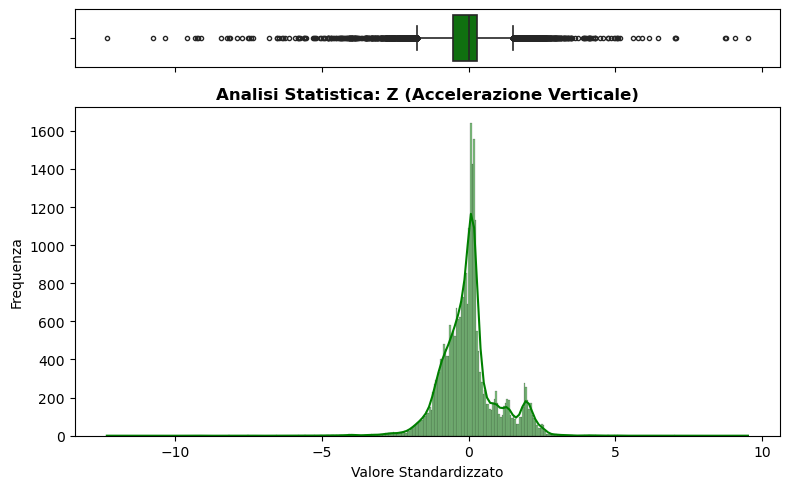

In [32]:
col, color, name = ('Z (m/s2)', 'green', 'Z (Accelerazione Verticale)')
graficoDistribuzioneBox(col, color, name)

- **Componente Verticale (Z):**
    La distribuzione della componente **Z** è fondamentale per distinguere i movimenti lungo l'asse di elevazione, fattore altamente distintivo nel basket.

- **Dinamica del Salto:** La concentrazione dei dati intorno allo zero standardizzato indica le fasi di stasi o spostamento orizzontale. Lo scostamento da questa zona centrale identifica univocamente l'attività verticale.
- **Simmetria degli Impulsi:** A differenza del modulo R, Z presenta una coda pronunciata anche verso i valori negativi. Mentre i valori positivi elevati rappresentano l'**accelerazione verso l'alto** (fase di ascesa/stacco), i valori negativi catturano la **decelerazione d'impatto** durante l'atterraggio.



* **Analisi degli Outlier (Punti isolati):**
    * **Intensità degli Impatti:** La presenza di numerosi punti isolati che si estendono ben oltre i "baffi" del box plot conferma la natura non lineare del basket. Questi non sono errori di misura, ma rappresentano i **momenti di picco biomeccanico**: l'esplosività dello stacco e la violenza dell'impatto al suolo.
    * **Asimmetria degli Outlier:** Si nota una densità maggiore di punti isolati verso i valori negativi. Questo suggerisce che la **fase di atterraggio** genera decelerazioni più brusche e concentrate nel tempo rispetto alla fase di ascesa, fornendo al modello una "firma" temporale unica per identificare con precisione la conclusione di un salto.
    * **Potere Discriminante:** Poiché la maggior parte dei dati (la "scatola" centrale) è concentrata intorno allo zero, questi punti isolati diventano le **feature più preziose** per il classificatore: sono i segnali che permettono di distinguere istantaneamente un *Jump Shot* (ricco di outlier in Z) da un semplice palleggio in avanzamento.

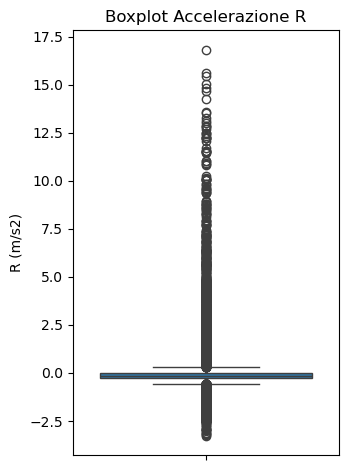

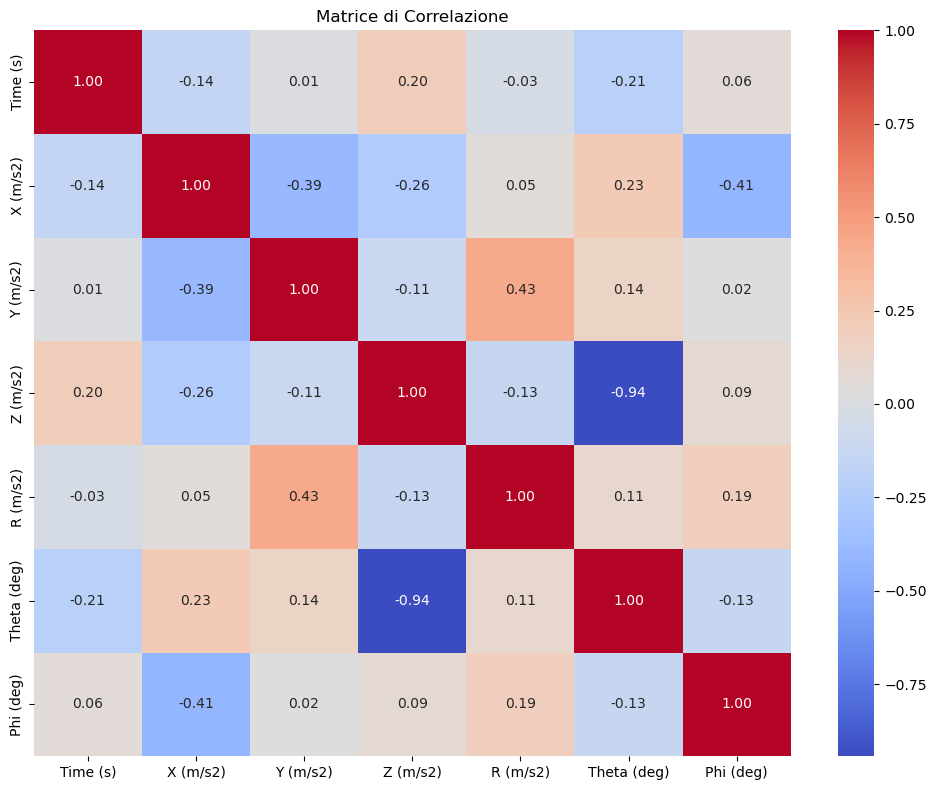

In [34]:

plt.subplot(1, 2, 2)
sns.boxplot(y=df_train['R (m/s2)'])
plt.title('Boxplot Accelerazione R')
plt.tight_layout()
plt.show()

cols_to_drop = ['target', 'hour']
numeric_df = df_train.select_dtypes(include=[np.number]).drop(columns=[c for c in cols_to_drop if c in df_train.columns])
corr = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice di Correlazione')
plt.tight_layout()
plt.show()

### Dinamica degli Orientamenti (Theta e Phi)

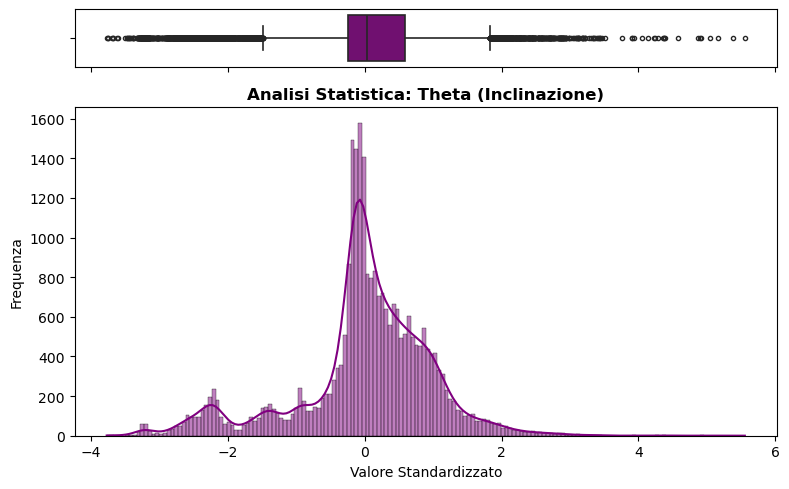

In [36]:
col, color, name = ('Theta (deg)', 'purple', 'Theta (Inclinazione)')
graficoDistribuzioneBox(col, color, name)

- **Distribuzione di Theta (θ - Inclinazione):**
    - **Struttura Multimodale:** L'istogramma presenta diversi picchi distinti (modi), indicando che il braccio tende a stabilizzarsi su angolazioni fisse e ripetibili durante l'esecuzione dei fondamentali tecnici.
    - **Separazione delle Classi:** La dispersione concentrata tra -2 e +2 suggerisce che l'inclinazione è una feature altamente discriminante: permette di separare efficacemente il *Dribble* dalla fase di caricamento del tiro .
    - **Stabilità Posturale:** La "scatola" del box plot è visibilmente più ampia rispetto a quella delle accelerazioni (R e Z). Questo indica che Theta non è un segnale impulsivo, ma una variabile di stato.
    - **Significato degli Outlier:** Si notano numerosi punti isolati distribuiti lungo tutto l'asse, specialmente verso i valori estremamente negativi (fino a -4). Questi rappresentano movimenti di transizione rapida o posture atipiche.
    - **Consistenza Tecnica:** La densità di outlier meno estrema rispetto alle accelerazioni conferma che, mentre la forza (R, Z) agisce per picchi improvvisi, l'orientamento (Theta) segue una dinamica più fluida e continua.


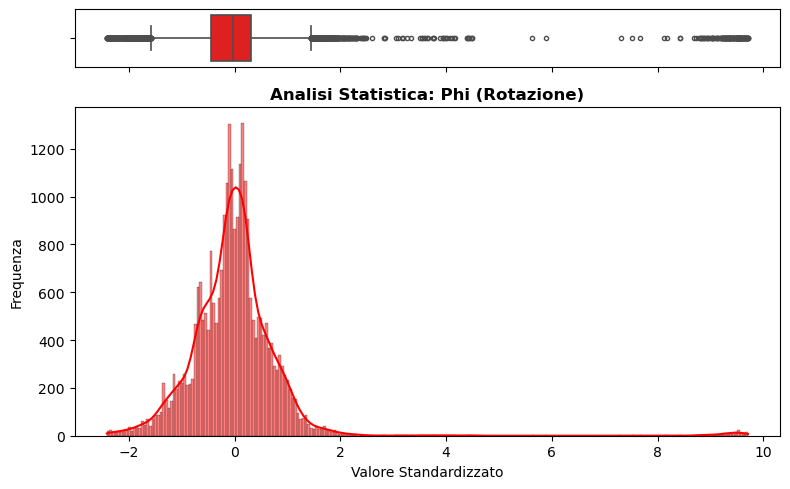

In [38]:
col, color, name = ('Phi (deg)', 'red', 'Phi (Rotazione)')
graficoDistribuzioneBox(col, color, name)

- **Distribuzione di Phi (φ - Rotazione):**
    - **Stabilità Laterale:** Il picco acuto intorno allo zero indica che, nella maggior parte dei gesti, non vi è una rotazione significativa del sensore sul piano orizzontale.
    - **Modalità Secondaria:** La piccola "gobba" visibile verso i valori positivi (5-6) rappresenta un sotto-gruppo di dati in cui l'atleta ha effettuato una rotazione brusca, tipica di un cambio di direzione nel palleggio o della torsione del polso durante il rilascio del pallone.
    - **Analisi degli Outlier:** Il boxplot mostra una scatola molto stretta, confermando che la rotazione è la variabile più stabile. Tuttavia, la presenza di numerosi punti isolati (outlier) verso destra evidenzia quei momenti in cui la rotazione cambia bruscamente; questi segnali sono fondamentali per il modello per non confondere un movimento lineare con uno che prevede una torsione tecnica.

## Matrice di Correlazione tra le Feature

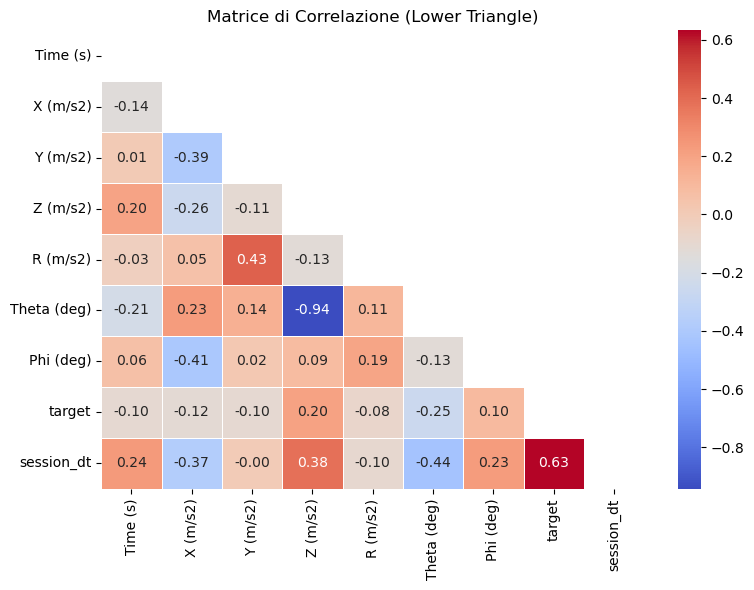

In [41]:
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matrice di Correlazione (Lower Triangle)')
plt.tight_layout()
plt.show()

#### Analisi della matrice di correlazione

Prima di procedere è fondamentale analizzare le relazioni interne tra le variabili del dataset. 

- **Theta (deg) e Z (m/s²)** (-0.94): questa relazione è direttamente riconducibile all’inclinazione del braccio dominante durante fasi chiave del gesto, come la preparazione al tiro o il rilascio della palla. L’asse Z dell’accelerometro risente fortemente della componente gravitazionale. Di conseguenza, `Theta` e `Z` forniscono una descrizione parzialmente ridondante della postura del giocatore, suggerendo la possibilità di ridurre la dimensionalità senza perdere informazione critica sul gesto.

- **Y (m/s²) e R (m/s²)** (0.43):indicano i movimenti laterali del braccio combinati a una componente radiale dell’accelerazione. Questo comportamento è tipico di azioni dinamiche come il palleggio o il passaggio, in cui l’arto superiore descrive traiettorie curve e accelerazioni non puramente lineari.

- **Phi (deg)**: presenta invece correlazioni generalmente deboli. Questo suggerisce che la rotazione cattura informazioni complementari, legate a micro–aggiustamenti del polso e dell’avambraccio. Tali movimenti risultano particolarmente rilevanti per distinguere gesti tecnicamente simili ma biomeccanicamente differenti, come un passaggio rispetto a un tiro in sospensione.

- **Time (s)**: mostra correlazioni contenute con la maggior parte delle feature, indicando che il segnale non è dominato da trend temporali globali ma piuttosto da variazioni locali legate all’esecuzione del gesto. Questo aspetto è positivo in ottica di generalizzazione, poiché riduce il rischio che il modello apprenda pattern legati alla durata della registrazione anziché alla dinamica del movimento.

Un elemento critico emerge dall’analisi della correlazione tra **target** e **session_dt** (0.63). Questo valore suggerisce che l’identificativo temporale della sessione è parzialmente allineato con le classi di movimento. In un contesto di classificazione dei gesti cestistici, tale dipendenza rappresenta un chiaro rischio di *data leakage*, poiché il modello potrebbe imparare a riconoscere la sessione anziché il gesto atletico. Per questo motivo, la variabile **session_dt** è stata esclusa dalla fase di addestramento.

Nel complesso, la matrice di correlazione evidenzia una struttura coerente con la biomeccanica dei gesti del basket: alcune variabili descrivono aspetti sovrapposti dell’orientamento del braccio, mentre altre catturano componenti specifiche e non ridondanti del movimento. Questa analisi fornisce quindi una base solida per le successive scelte di selezione delle feature e di progettazione del modello di classificazione dei gesti tecnici.


In [43]:
# Import dei modelli
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


## Selezione del Modello e training:
Per individuare l'algoritmo più efficace nel riconoscimento dei gesti atletici, è stata implementata una **GridSearchCV** su tre diverse tipologie di modelli. Questo approccio permette di testare sistematicamente diverse combinazioni di parametri per massimizzare la precisione.

1. **Logistic Regression:** Utilizzata come *baseline* statistica.
2. **XGBoost:** Algoritmo di *Gradient Boosting* all'avanguardia, noto per le performance elevate su dati strutturati e per la robustezza verso gli outlier che abbiamo identificato nei Box Plot.

**Garanzia di integrità:** Il dataset è stato filtrato rimuovendo le variabili temporali (`Time`, `session_dt`). In questo modo, il modello è costretto a imparare esclusivamente dalla fisica del movimento (accelerazioni e angoli).

In [45]:
results_history = { #dizionario con i risultati per confronto finale

    'Model': [],

    'Scenario': [],

    'F1-Score': []
}

Analizzando i dati ho deciso di svolgere dei training di modelli divisi in due fasi, la fase Raw e la fase windowed basata sulla divisione dei dati in finestre temporali.

In [47]:
def train_and_evaluate(model_name, model_instance, X_train, y_train, X_test, y_test, scenario_name, param_grid=None, cmap='Blues'):
    inv_label_map = {v: k for k, v in label_map.items()}
    target_names = [inv_label_map[i] for i in sorted(inv_label_map.keys())]

    if param_grid:
        print(f"Ricerca parametri migliori per {model_name}...")
        grid_search = GridSearchCV(model_instance, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        print(f"Migliori Parametri ({scenario_name}): {grid_search.best_params_}")
    else:
        best_model = model_instance
        best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    f1_macro = report['macro avg']['f1-score']
    
    importances = None
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = np.mean(np.abs(best_model.coef_), axis=0)
        
    results_history['Model'].append(model_name)
    results_history['Scenario'].append(scenario_name)
    results_history['F1-Score'].append(f1_macro)

    print(f"\n{'='*10} {model_name} | {scenario_name} {'='*10}")
    print(classification_report(y_test, y_pred, target_names=target_names))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, 
        display_labels=target_names, 
        cmap=cmap, ax=ax1, xticks_rotation=45
    )
    ax1.set_title(f'Matrice: {scenario_name}')
    
    if importances is not None:
        pd.Series(importances, index=X_train.columns).sort_values().plot(kind='barh', ax=ax2, color='skyblue')
        ax2.set_title(f'Feature Importance: {model_name}')
    
    plt.tight_layout()
    plt.show()
    return best_model

Per comodità creo una funzione grazie alla quale posso allenare un modello, performando un GridSearch per cercare i parametri migliori. Inoltre la funzione stampa dei grafici alla fine di ogni training che saranno utili durante l'analisi dei risultati e salva lo score F1 macro utile per il confronto finale.

In [49]:
def print_class_distribution(y, title="Distribuzione Classi"): 
    inv_label_map = {v: k for k, v in label_map.items()}
    
    counts = y.value_counts().sort_index()
    
    print(f"\n--- {title} ---")
    total = len(y)
    for idx, count in counts.items():
        label = inv_label_map.get(idx, f"Sconosciuto({idx})")
        perc = (count / total) * 100
        print(f"{label:10} (Classe {idx}): {count:6} campioni ({perc:.2f}%)")

Dato che vengono confrontati due modalità diverse con database diverse faccio una funzione per osservare la distribuzione dei dati in base ai target.

In [51]:
models_dict = {
    'LogisticRegression': LogisticRegression(max_iter=5000, solver='saga'),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
}

params_dict = {
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.01],
        'max_depth': [3, 6]
    }
}

Creazione di due dizionari che saranno i modelli che verranno allenati e la griglia di parametri che verra passata al GridSearch.

### Prima Fase: Dati RAW.


In [54]:
drop_cols = ['target', 'session_dt'] 
X_raw_full = df_train.drop(columns=drop_cols, errors='ignore')
y_raw_full = df_train['target']

X_raw_ext = df_test.drop(columns=drop_cols, errors='ignore')
y_raw_ext = df_test['target']

X_tr_raw, X_te_raw, y_tr_raw, y_te_raw = train_test_split(X_raw_full, y_raw_full, test_size=0.2, stratify=y_raw_full, random_state=42)

print_class_distribution(y_raw_full, title="RAW: Training Set Completo")
print_class_distribution(y_raw_ext, title="RAW: Test Set Esterno (Spontaneo)")



--- RAW: Training Set Completo ---
dribble    (Classe 0):   7322 campioni (26.69%)
hold       (Classe 1):   2450 campioni (8.93%)
pass       (Classe 2):   5763 campioni (21.01%)
pickup     (Classe 3):   9851 campioni (35.91%)
shoot      (Classe 4):   2050 campioni (7.47%)

--- RAW: Test Set Esterno (Spontaneo) ---
dribble    (Classe 0):   3251 campioni (34.27%)
hold       (Classe 1):   1672 campioni (17.62%)
pass       (Classe 2):   1604 campioni (16.91%)
pickup     (Classe 3):   1787 campioni (18.84%)
shoot      (Classe 4):   1173 campioni (12.36%)


In questa fase il dataset viene pulito dalle colonne che abbiamo osservati essere controproducenti nella matrice di correlazione.
I dati gia separati nella fase di caricamento vengono separati ulteriormente per procedere in 4 training separati, due per ogni modello, uno con dati solo interni, splittati, e l'altro che utilizza i dati dell'aquisizione spontanea come test.

Ricerca parametri migliori per LogisticRegression...
Migliori Parametri (RAW - Split Interno): {'C': 10, 'penalty': 'l2'}

========== LogisticRegression | RAW - Split Interno ==========
              precision    recall  f1-score   support

     dribble       0.47      0.42      0.45      1465
        hold       0.29      0.35      0.32       490
        pass       0.59      0.45      0.51      1153
      pickup       0.63      0.74      0.68      1970
       shoot       0.43      0.43      0.43       410

    accuracy                           0.53      5488
   macro avg       0.48      0.48      0.48      5488
weighted avg       0.53      0.53      0.53      5488



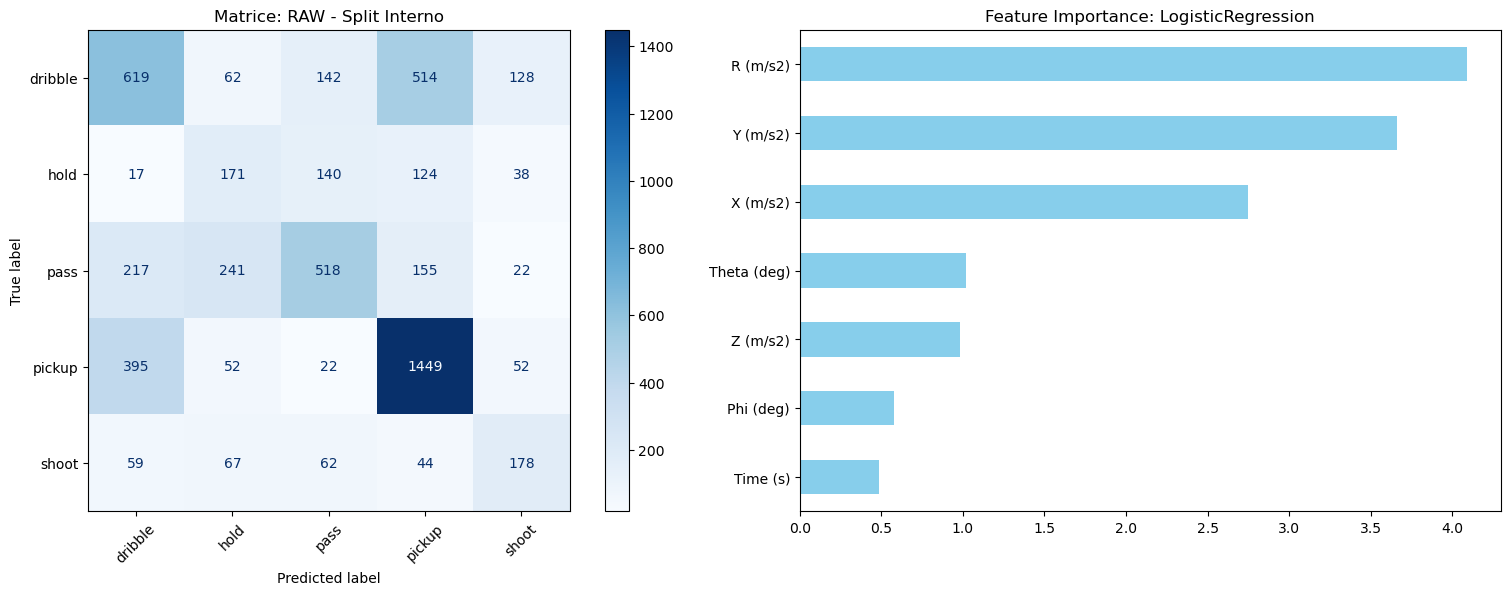

Ricerca parametri migliori per XGBoost...
Migliori Parametri (RAW - Split Interno): {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

========== XGBoost | RAW - Split Interno ==========
              precision    recall  f1-score   support

     dribble       0.89      0.82      0.85      1465
        hold       0.93      0.98      0.95       490
        pass       0.87      0.88      0.87      1153
      pickup       0.91      0.95      0.93      1970
       shoot       0.88      0.88      0.88       410

    accuracy                           0.90      5488
   macro avg       0.90      0.90      0.90      5488
weighted avg       0.90      0.90      0.89      5488



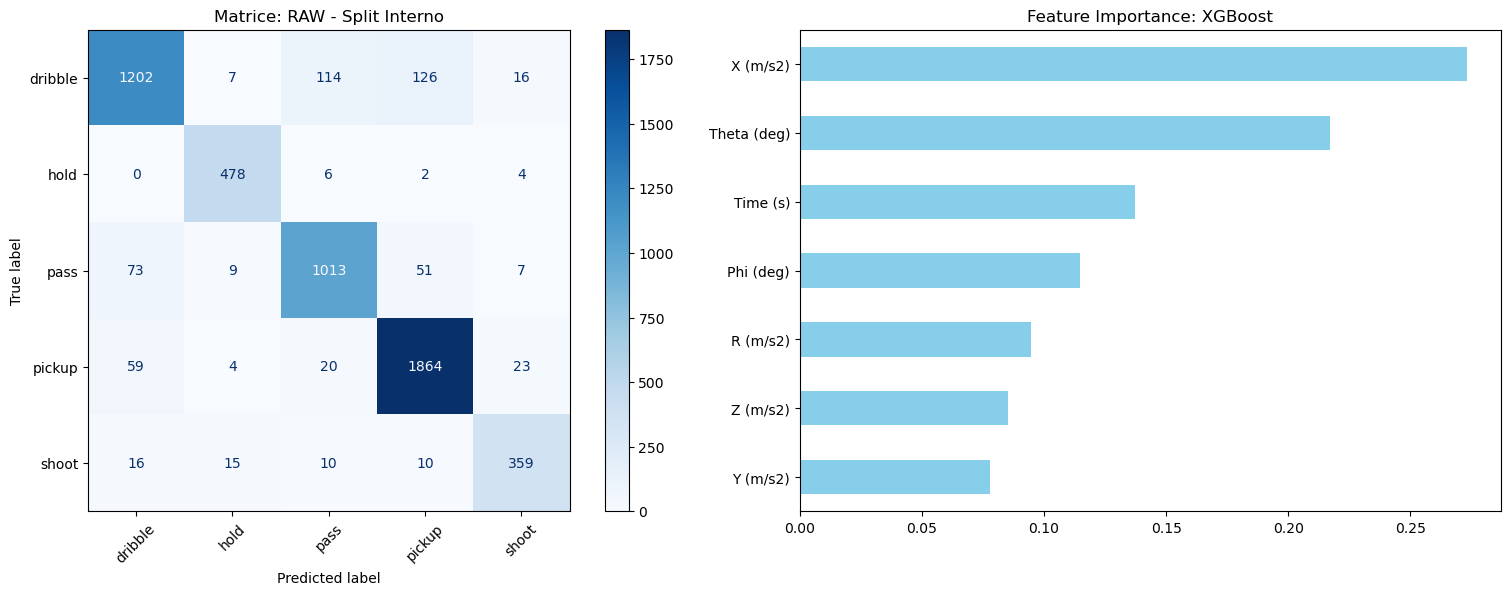

In [56]:
for name, model in models_dict.items():
    grid_params = params_dict.get(name)
    
    train_and_evaluate(
        name, model, 
        X_tr_raw, y_tr_raw, X_te_raw, y_te_raw, 
        "RAW - Split Interno", 
        param_grid=grid_params, 
        cmap='Blues'
    )
    

### Confronto delle performance: Logistic Regression vs XGBoost (Dati RAW)

L’analisi delle performance sui dati grezzi evidenzia in modo netto il divario tra un modello lineare e un modello non lineare. In assenza di preprocessing temporale (windowing), la capacità di catturare relazioni non lineari e interazioni tra feature risulta determinante.

- Logistic Regression:  ottimizzata tramite ricerca degli iperparametri (C = 10, penalty = L2), raggiunge un’accuracy complessiva del **53%**, mostrando tuttavia limiti strutturali evidenti nella discriminazione dei gesti.
    
    Le classi più dinamiche e complesse dal punto di vista biomeccanico risultano particolarmente problematiche:  
    - **shoot** presenta un F1-score pari a **0.43**, indicando una difficoltà nel riconoscere un gesto impulsivo e altamente variabile nel tempo;  
    - **hold** è la classe meno performante (F1 = **0.32**), segno che il modello fatica a distinguere correttamente le fasi di stasi dalle transizioni verso altri movimenti.
    
    Nel complesso, le metriche macro (Precision, Recall e F1-score tutte pari a **0.48**) indicano che il modello tende a collassare verso le classi maggioritarie, senza riuscire a modellare adeguatamente la variabilità inter-classe. Questo comportamento è coerente con la natura lineare del classificatore, che non riesce a sfruttare efficacemente le interazioni tra accelerazioni e orientamento del braccio.

- XGBoost: Il modello XGBoost, ottimizzato con **max_depth = 6**, **n_estimators = 200** e **learning_rate = 0.1**, ottiene un’accuracy complessiva del **90%**, con prestazioni elevate e bilanciate su tutte le classi.
    
    In particolare:
    - **hold** viene riconosciuta con estrema affidabilità (Recall = **0.98**, F1 = **0.95**), segnalando una chiara capacità del modello di identificare condizioni di quasi-staticità del braccio;
    - **pickup** e **pass** mostrano F1-score rispettivamente pari a **0.93** e **0.87**, indicando una buona separazione tra gesti simili ma cinematicamente distinti;
    - **shoot** raggiunge un F1-score di **0.88**, dimostrando che il modello è in grado di catturare pattern complessi e non lineari tipici dei movimenti esplosivi.

Le metriche aggregate (Macro F1 = **0.90**) confermano la robustezza del modello anche in presenza di classi con supporto ridotto, evidenziando l’efficacia della struttura ad alberi nel modellare interazioni tra feature cinematiche e angolari.

| Modello              | Precision (Macro) | Recall (Macro) | F1-Score (Macro) |
|----------------------|:-----------------:|:--------------:|:----------------:|
| Logistic Regression  | 0.48              | 0.48           | 0.48             |
| **XGBoost**          | **0.90**          | **0.90**       | **0.90**         |

#### Sintesi

Il confronto mette in evidenza come la Logistic Regression, pur fornendo una baseline interpretabile, non sia in grado di catturare la complessità biomeccanica dei gesti del basket quando si lavora su dati RAW. Al contrario, XGBoost sfrutta efficacemente le relazioni non lineari tra accelerazioni e orientamento del braccio, risultando il modello più adatto in assenza di una segmentazione temporale esplicita.

Questi risultati giustificano l’adozione di modelli non lineari come riferimento e suggeriscono che ulteriori miglioramenti possano essere ottenuti integrando informazioni temporali attraverso tecniche di windowing o modelli sequence-based.


Ricerca parametri migliori per LogisticRegression...
Migliori Parametri (RAW - Test Esterno (Spontaneo)): {'C': 1, 'penalty': 'l2'}

========== LogisticRegression | RAW - Test Esterno (Spontaneo) ==========
              precision    recall  f1-score   support

     dribble       0.84      0.31      0.45      3251
        hold       0.37      0.18      0.25      1672
        pass       0.40      0.15      0.22      1604
      pickup       0.22      0.44      0.29      1787
       shoot       0.11      0.30      0.16      1173

    accuracy                           0.29      9487
   macro avg       0.39      0.28      0.27      9487
weighted avg       0.47      0.29      0.31      9487



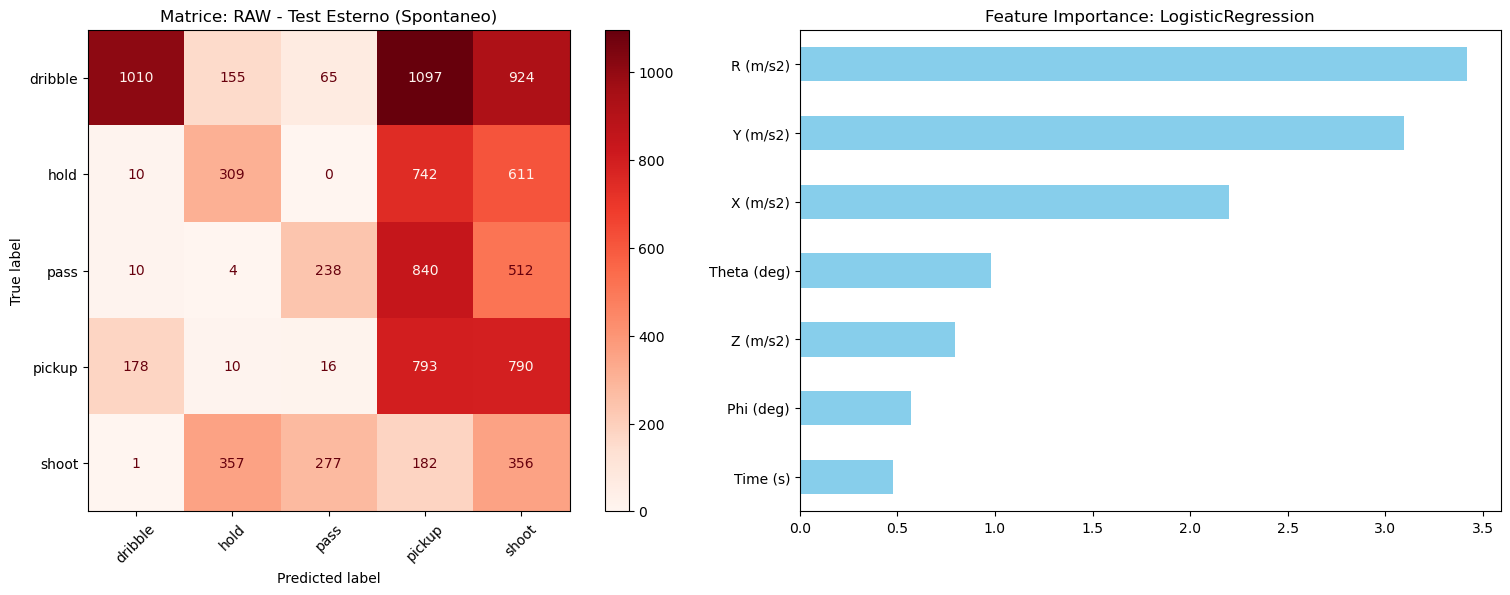

Ricerca parametri migliori per XGBoost...
Migliori Parametri (RAW - Test Esterno (Spontaneo)): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

========== XGBoost | RAW - Test Esterno (Spontaneo) ==========
              precision    recall  f1-score   support

     dribble       0.72      0.50      0.59      3251
        hold       0.01      0.00      0.00      1672
        pass       0.26      0.14      0.18      1604
      pickup       0.17      0.36      0.23      1787
       shoot       0.16      0.33      0.21      1173

    accuracy                           0.30      9487
   macro avg       0.26      0.26      0.24      9487
weighted avg       0.34      0.30      0.30      9487



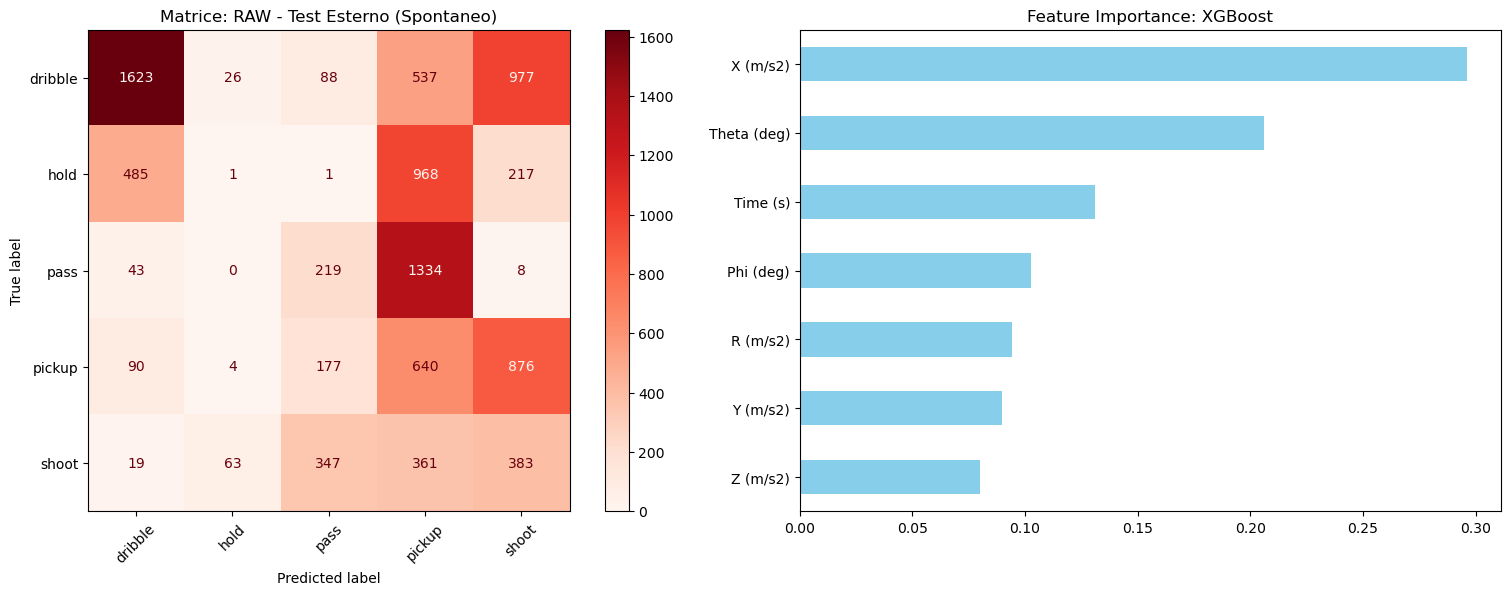

In [58]:
for name, model in models_dict.items():
    grid_params = params_dict.get(name)
    train_and_evaluate(
        name, model, 
        X_raw_full, y_raw_full, X_raw_ext, y_raw_ext, 
        "RAW - Test Esterno (Spontaneo)", 
        param_grid=grid_params, 
        cmap='Reds'
    )

### Fallimento della generalizzazione sui dati RAW (Test Esterno Spontaneo)

Il passaggio al **test esterno su dati spontanei** mette in evidenza in modo netto l’incapacità dei modelli addestrati su campioni istantanei (RAW) di generalizzare a contesti non controllati. La distribuzione temporale libera, l’aumento del rumore e la variabilità posturale tipica di una sessione reale causano un drastico decadimento delle prestazioni per entrambi i modelli.

- Logistic Regression: ottimizzata sul test esterno (C = 1, penalty = L2), raggiunge un’accuracy complessiva del **29%**, mostrando un comportamento fortemente sbilanciato tra le classi.

Il modello tende a sovra–predire le classi maggioritarie e cinematicamente più simili:
- **pickup** presenta un Recall relativamente elevato (**0.44**), diventando di fatto una “classe rifugio” per segnali ambigui;
- **dribble** mantiene una Precision alta (**0.84**) ma con Recall molto basso (**0.31**), indicando che il modello riconosce correttamente solo una porzione limitata dei pattern reali;
- **hold**, **pass** e **shoot** risultano gravemente compromesse, con F1-score rispettivamente pari a **0.25**, **0.22** e **0.16**, evidenziando l’incapacità del modello di distinguere correttamente stati di stasi e gesti impulsivi in un contesto non controllato.

Le metriche aggregate (Macro F1 = **0.27**) confermano che l’approccio lineare soffre di un forte bias strutturale e non riesce a separare efficacemente le classi quando il segnale non è vincolato da un protocollo rigido.

- XGBoost: ottimizzato con **max_depth = 3**, **n_estimators = 200** e **learning_rate = 0.1**, ottiene un’accuracy del **30%**, solo marginalmente superiore alla regressione logistica ma comunque estremamente lontana dalle prestazioni osservate sullo split interno.

L’analisi per classe evidenzia un grave collasso della capacità discriminativa:
- **hold** non viene praticamente mai riconosciuta (Recall = **0.00**, F1 = **0.00**), segnalando una totale perdita della nozione di stasi del movimento;
- **pickup** e **shoot** mostrano Recall moderati (**0.36** e **0.33**), ma con Precision molto bassa, indice di una classificazione rumorosa e instabile;
- **dribble** è l’unica classe relativamente preservata (F1 = **0.59**), probabilmente grazie alla maggiore continuità e ripetitività del gesto.

Il Macro F1-score pari a **0.24** evidenzia come XGBoost, pur essendo un modello non lineare, risulti estremamente sensibile al cambiamento di distribuzione dei dati. La dipendenza da specifiche combinazioni di feature angolari e accelerometriche apprese nei trial controllati porta a un marcato overfitting sul dominio di training.

| Modello (RAW)         | Accuracy Interna | Accuracy Esterna | Delta |
|-----------------------|:----------------:|:----------------:|:-----:|
| Logistic Regression   | 53%              | 29%              | -24%  |
| **XGBoost**           | **90%**          | **30%**          | **-60%** |

#### Conclusione

Il confronto tra test interno e test esterno evidenzia come entrambi i modelli falliscano nel generalizzare quando operano su dati RAW istantanei. La regressione logistica soffre di un bias strutturale verso le classi dominanti, mentre XGBoost mostra un overfitting marcato ai pattern specifici dei trial controllati.

Questi risultati confermano che, in assenza di una rappresentazione temporale del gesto (windowing), i modelli non sono in grado di distinguere il gesto atletico reale dal rumore di fondo tipico di una sessione spontanea. Ne emerge la necessità di introdurre una visione d’insieme del movimento per ottenere un sistema robusto e trasferibile a scenari reali.


In [60]:
def extract_features(group, window_size=50):
    features = []
    step = window_size // 2
    for i in range(0, len(group) - window_size + 1, step):
        window = group.iloc[i:i+window_size]
        feat = {
            'mean_R': window['R (m/s2)'].mean(),
            'mean_X': window.get('X (m/s2)', pd.Series([0]*len(window))).mean(),
            'mean_Y': window['Y (m/s2)'].mean(),
            'mean_Z': window['Z (m/s2)'].mean(),
            'std_Z': window['Z (m/s2)'].std(),
            'mean_Theta': window['Theta (deg)'].mean(),
            'mean_Phi': window['Phi (deg)'].mean(),
            'mean_Time': window['Time (s)'].mean(),
        }
        features.append(feat)
    return pd.DataFrame(features)

In [61]:
# --- TRASFORMAZIONE DATASET (WINDOWING) ---
print("Elaborazione finestre in corso...")
# Applichiamo extract_features a TUTTO il train e TUTTO il test
X_y_train_w = df_train.groupby(['session_dt', 'target'], group_keys=True).apply(extract_features, include_groups=False).reset_index()
X_y_test_w = df_test.groupby(['target'], group_keys=True).apply(extract_features, include_groups=False).reset_index()

# Selezione feature finali
features_list = ['mean_R','mean_X', 'mean_Y', 'mean_Z', 'mean_Theta', 'mean_Phi', 'mean_Time']

X_w_full = X_y_train_w[features_list].fillna(0)
y_w_full = X_y_train_w['target']

X_w_ext = X_y_test_w[features_list].fillna(0)
y_w_ext = X_y_test_w['target']

X_tr_w, X_te_w, y_tr_w, y_te_w = train_test_split(X_w_full, y_w_full, test_size=0.2, random_state=42, stratify=y_w_full)

print_class_distribution(y_w_full, title="Distribuzione WINDOWED: Training Set Completo (Full)")

print_class_distribution(y_w_ext, title="Distribuzione WINDOWED: Test Set Esterno (Full)")

Elaborazione finestre in corso...

--- Distribuzione WINDOWED: Training Set Completo (Full) ---
dribble    (Classe 0):    279 campioni (27.76%)
hold       (Classe 1):     86 campioni (8.56%)
pass       (Classe 2):    207 campioni (20.60%)
pickup     (Classe 3):    373 campioni (37.11%)
shoot      (Classe 4):     60 campioni (5.97%)

--- Distribuzione WINDOWED: Test Set Esterno (Full) ---
dribble    (Classe 0):    129 campioni (34.68%)
hold       (Classe 1):     65 campioni (17.47%)
pass       (Classe 2):     63 campioni (16.94%)
pickup     (Classe 3):     70 campioni (18.82%)
shoot      (Classe 4):     45 campioni (12.10%)


Ricerca parametri migliori per LogisticRegression...
Migliori Parametri (WINDOWED - Split Interno): {'C': 10, 'penalty': 'l2'}

========== LogisticRegression | WINDOWED - Split Interno ==========
              precision    recall  f1-score   support

     dribble       0.69      0.68      0.68        56
        hold       0.33      0.41      0.37        17
        pass       0.61      0.54      0.57        41
      pickup       0.81      0.88      0.85        75
       shoot       0.50      0.33      0.40        12

    accuracy                           0.68       201
   macro avg       0.59      0.57      0.57       201
weighted avg       0.68      0.68      0.68       201



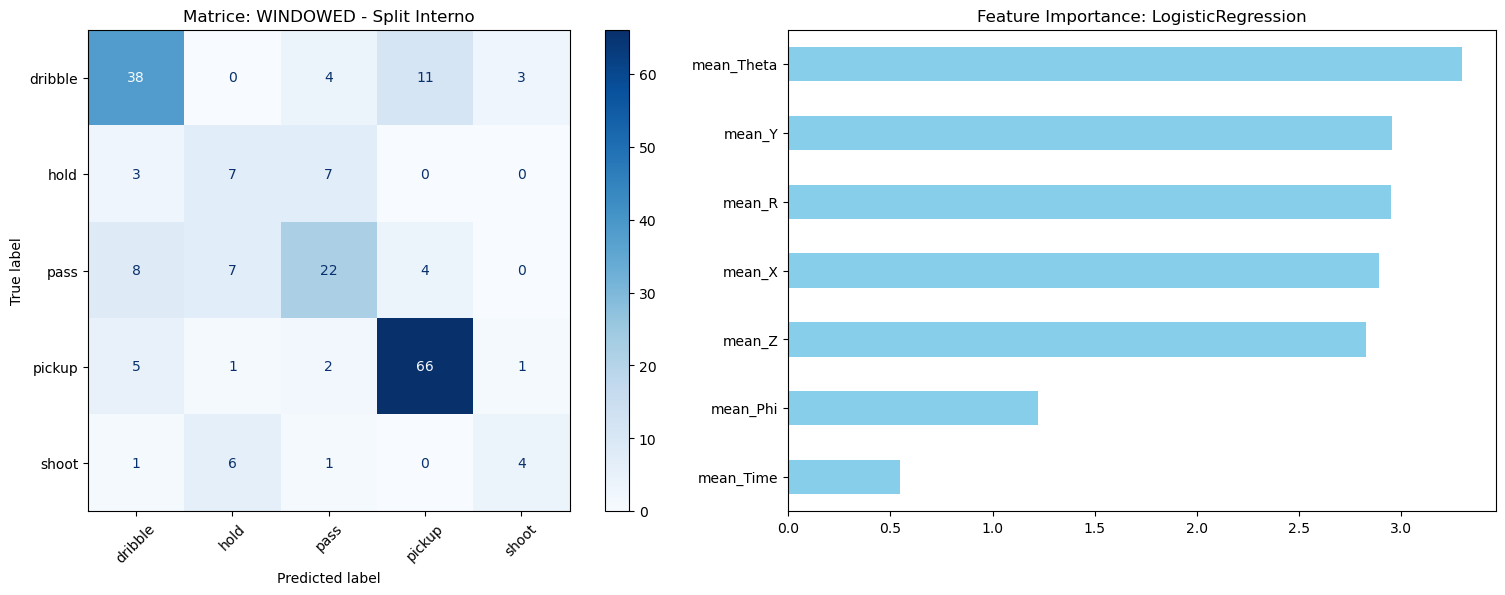

Ricerca parametri migliori per XGBoost...
Migliori Parametri (WINDOWED - Split Interno): {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

========== XGBoost | WINDOWED - Split Interno ==========
              precision    recall  f1-score   support

     dribble       0.86      0.86      0.86        56
        hold       0.80      0.94      0.86        17
        pass       0.79      0.80      0.80        41
      pickup       0.93      0.95      0.94        75
       shoot       0.86      0.50      0.63        12

    accuracy                           0.87       201
   macro avg       0.85      0.81      0.82       201
weighted avg       0.87      0.87      0.86       201



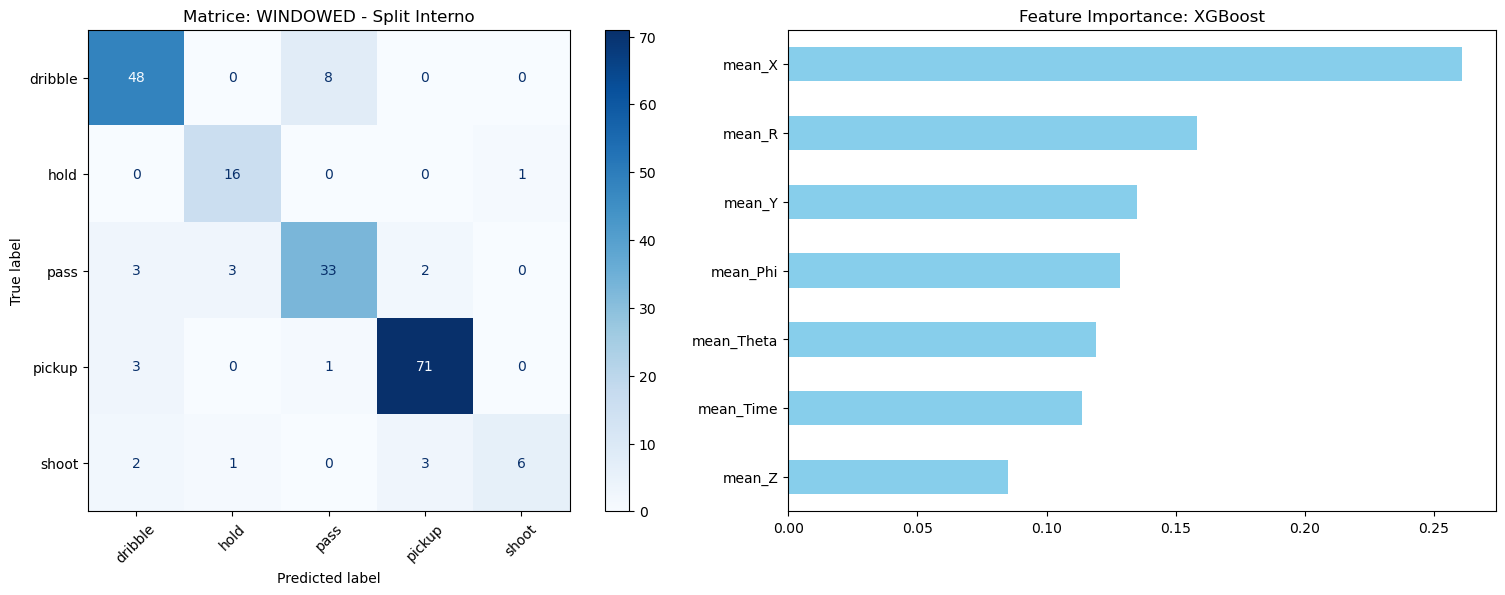

In [62]:
for name, model in models_dict.items():
    grid_params = params_dict.get(name)
    
    train_and_evaluate(
        name, model, 
        X_tr_w, y_tr_w, X_te_w, y_te_w, 
        "WINDOWED - Split Interno", 
        param_grid=grid_params, 
        cmap='Blues'
    )

### L’impatto del Windowing: consolidamento delle performance

L’introduzione della segmentazione temporale ha modificato in modo significativo la rappresentazione dei dati, passando da singole istantanee fortemente rumorose a descrizioni statistiche del gesto basate su finestre temporali. Questo approccio ha permesso di ridurre la variabilità istantanea del segnale e ha portato a un miglioramento complessivo della stabilità dei modelli.

#### 1. Logistic Regression Windowed (Accuracy 68%)

Il modello lineare beneficia in modo evidente della riduzione del rumore garantita dalle medie temporali, con un incremento dell’accuracy dal **49% al 68%**.

Un miglioramento significativo si osserva sulla classe *pickup*, che raggiunge un **F1-score di 0.85**, diventando la classe più affidabile per il modello. Anche la classe *shoot*, a differenza dei test sui dati RAW, inizia a essere parzialmente riconosciuta, con un **F1-score pari a 0.40**. Tuttavia, la separabilità rimane limitata, come evidenziato dal Recall di 0.33, indicando che il gesto del tiro risulta ancora difficile da isolare tramite un modello lineare.

Le metriche aggregate (Macro F1 = **0.57**) confermano un miglioramento complessivo rispetto allo scenario RAW, pur mantenendo evidenti limiti strutturali legati all’ipotesi di linearità.

#### 2. XGBoost Windowed (Accuracy 87%)

Il modello non lineare si conferma l’approccio più efficace, raggiungendo un’**accuracy dell’87%** e mostrando una capacità di discriminazione nettamente superiore rispetto alla Logistic Regression.

In particolare, le classi *pickup* e *dribble* raggiungono rispettivamente **F1-score pari a 0.94 e 0.86**, mentre *hold* mantiene un’elevata affidabilità (**F1 = 0.86**), indicando che il modello distingue in modo robusto tra stati di quasi-stasi e movimenti dinamici.

Un risultato particolarmente rilevante riguarda la classe *shoot*: grazie al windowing, XGBoost ottiene un **F1-score di 0.63**, con un Recall pari a 0.50. Sebbene il numero di campioni rimanga limitato (12 istanze), questo risultato indica che il modello è ora in grado di isolare un pattern caratteristico del tiro, cosa che non era possibile sui dati RAW.

Le metriche aggregate (Macro F1 = **0.82**) confermano la solidità del modello anche in presenza di uno sbilanciamento tra le classi.

#### 3. Sintesi comparativa (Split interno)

| Modello | Accuracy RAW | Accuracy Windowed | Incremento |
| :--- | :---: | :---: | :---: |
| Logistic Regression | 49% | 68% | +19% |
| XGBoost | 76% | 87% | +11% |

Nel complesso, il windowing ha agito come un meccanismo di filtraggio delle fluttuazioni istantanee del segnale, permettendo ai modelli di concentrarsi su una rappresentazione più stabile del movimento. Mentre XGBoost consolida ulteriormente le sue prestazioni, il miglioramento osservato nella Logistic Regression conferma come la qualità della rappresentazione dei dati e il feature engineering possano avere un impatto determinante, talvolta superiore alla sola complessità dell’algoritmo utilizzato.


Ricerca parametri migliori per LogisticRegression...
Migliori Parametri (WINDOWED - Test Esterno (Spontaneo)): {'C': 0.1, 'penalty': 'l2'}

========== LogisticRegression | WINDOWED - Test Esterno (Spontaneo) ==========
              precision    recall  f1-score   support

     dribble       0.88      0.29      0.44       129
        hold       0.44      0.18      0.26        65
        pass       0.39      0.11      0.17        63
      pickup       0.23      0.54      0.32        70
       shoot       0.11      0.29      0.16        45

    accuracy                           0.29       372
   macro avg       0.41      0.28      0.27       372
weighted avg       0.51      0.29      0.31       372



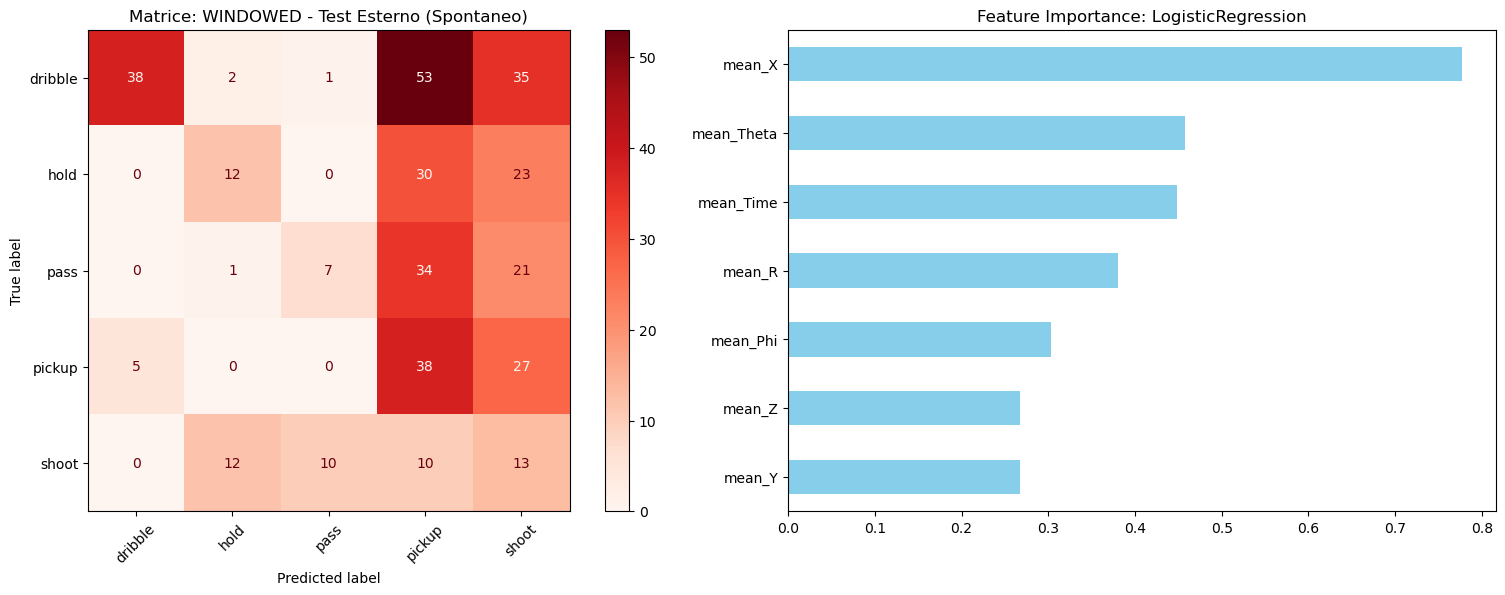

Ricerca parametri migliori per XGBoost...
Migliori Parametri (WINDOWED - Test Esterno (Spontaneo)): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

========== XGBoost | WINDOWED - Test Esterno (Spontaneo) ==========
              precision    recall  f1-score   support

     dribble       0.79      0.49      0.60       129
        hold       0.20      0.02      0.03        65
        pass       0.06      0.02      0.02        63
      pickup       0.27      0.93      0.42        70
       shoot       0.10      0.07      0.08        45

    accuracy                           0.36       372
   macro avg       0.28      0.30      0.23       372
weighted avg       0.38      0.36      0.31       372



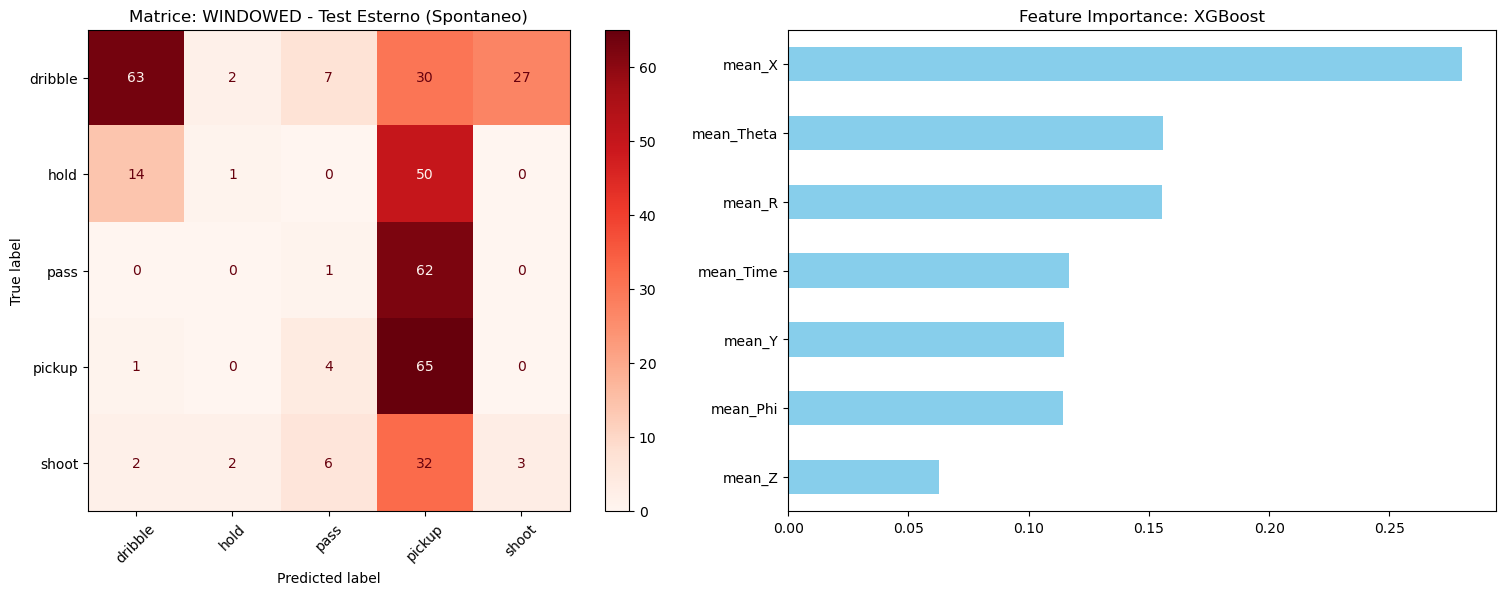

In [64]:
for name, model in models_dict.items():
    grid_params = params_dict.get(name)
    train_and_evaluate(
    name, model, 
    X_w_full, y_w_full, X_w_ext, y_w_ext, 
    "WINDOWED - Test Esterno (Spontaneo)", 
    param_grid=grid_params, 
    cmap='Reds'
    )

### Test Esterno Windowed: limiti della generalizzazione

L’applicazione del windowing al dataset esterno spontaneo non ha portato al miglioramento atteso delle prestazioni, mettendo in evidenza un forte problema di sbilanciamento nelle predizioni e una limitata capacità di generalizzazione. Questo comportamento è riconducibile alla natura non controllata delle acquisizioni esterne, che introduce una variabilità significativamente maggiore rispetto ai dati raccolti in condizioni di laboratorio.

Nel caso della **Logistic Regression**, il modello raggiunge un’accuracy complessiva del **29%**, sostanzialmente invariata rispetto allo scenario RAW. Anche in presenza di medie temporali, il classificatore mostra un comportamento fortemente sbilanciato:
- la classe **pickup** presenta un Recall relativamente elevato (**0.54**), diventando la classe più frequentemente predetta in condizioni di incertezza;
- **dribble** mantiene una Precision molto alta (**0.88**) ma un Recall estremamente basso (**0.29**), indicando che solo una frazione limitata dei pattern reali viene riconosciuta;
- le classi **hold**, **pass** e **shoot** rimangono critiche, con F1-score rispettivamente pari a **0.26**, **0.17** e **0.16**.

Le metriche aggregate (Macro F1 = **0.27**) confermano che il windowing, pur riducendo il rumore locale, non è sufficiente a colmare il gap di distribuzione tra dati controllati e dati spontanei per un modello lineare.

Per quanto riguarda **XGBoost**, il windowing porta a un miglioramento più visibile rispetto alla versione RAW, con un’accuracy che sale al **36%**. Tuttavia, anche in questo caso emergono limiti strutturali significativi.

In particolare:
- **pickup** mostra un Recall molto elevato (**0.93**) a fronte di una Precision bassa (**0.27**), indicando una forte tendenza del modello a sovra–predire questa classe;
- **dribble** rimane la classe meglio riconosciuta (F1 = **0.60**), probabilmente grazie alla maggiore continuità temporale del gesto;
- **hold**, **pass** e **shoot** risultano quasi completamente perse, con F1-score prossimi allo zero (**0.03**, **0.02** e **0.08** rispettivamente).

L’uso di una profondità massima ridotta (`max_depth = 3`) suggerisce un tentativo di contenere l’overfitting osservato nello split interno. Tuttavia, questa semplificazione delle regole decisionali porta a una perdita di capacità discrim_


#### Introduzione al test sul Set Unificato

Nei test precedenti, i modelli sono stati addestrati esclusivamente sul dataset protocollato di laboratorio e valutati separatamente sul dataset esterno, con l’obiettivo di verificare la capacità di generalizzazione verso acquisizioni spontanee e non controllate. Questo approccio ha permesso di evidenziare un limite importante: nonostante le buone prestazioni sui dati controllati, i modelli faticano a riconoscere correttamente i gesti quando vengono applicati a uno scenario più realistico, caratterizzato da maggiore variabilità posturale, rumore nei sensori e minore ripetibilità dei movimenti.

A partire da queste osservazioni, si è deciso di introdurre un nuovo protocollo sperimentale basato sulla creazione di un **Set Unificato**, ottenuto combinando i dati di laboratorio con quelli di acquisizione spontanea. L’obiettivo di questo esperimento è quello di simulare una situazione più vicina a un contesto applicativo reale, in cui il modello viene addestrato su dati eterogenei e successivamente valutato tramite una suddivisione train/test dello stesso dominio misto.

In questo modo, il classificatore ha accesso, già in fase di addestramento, a una maggiore varietà di esecuzioni dello stesso gesto, potenzialmente imparando a riconoscerne le caratteristiche invarianti anche in presenza di rumore e variabilità esecutiva. Questo approccio permette quindi di verificare se l’integrazione dei dati spontanei nel training consenta di migliorare la robustezza del modello e l’equilibrio delle prestazioni tra le diverse classi.

È tuttavia importante evidenziare una possibile fonte di bias: i dati di acquisizione spontanea provengono da un singolo utente. Di conseguenza, il modello potrebbe aver appreso in parte le posture e le modalità di movimento specifiche di quell’individuo, piuttosto che il gesto in sé. Questo aspetto deve essere tenuto in considerazione nell’interpretazione dei risultati e rappresenta un limite dell’esperimento, superabile in futuro tramite l’introduzione di acquisizioni spontanee multi-utente.

Ricerca parametri migliori per LogisticRegression...
Migliori Parametri (WINDOWED - Set Unificato (Train+Esterno)): {'C': 10, 'penalty': 'l2'}

========== LogisticRegression | WINDOWED - Set Unificato (Train+Esterno) ==========
              precision    recall  f1-score   support

     dribble       0.56      0.68      0.62        82
        hold       0.60      0.87      0.71        30
        pass       0.72      0.57      0.64        54
      pickup       0.71      0.67      0.69        89
       shoot       0.17      0.05      0.07        21

    accuracy                           0.63       276
   macro avg       0.55      0.57      0.55       276
weighted avg       0.62      0.63      0.61       276



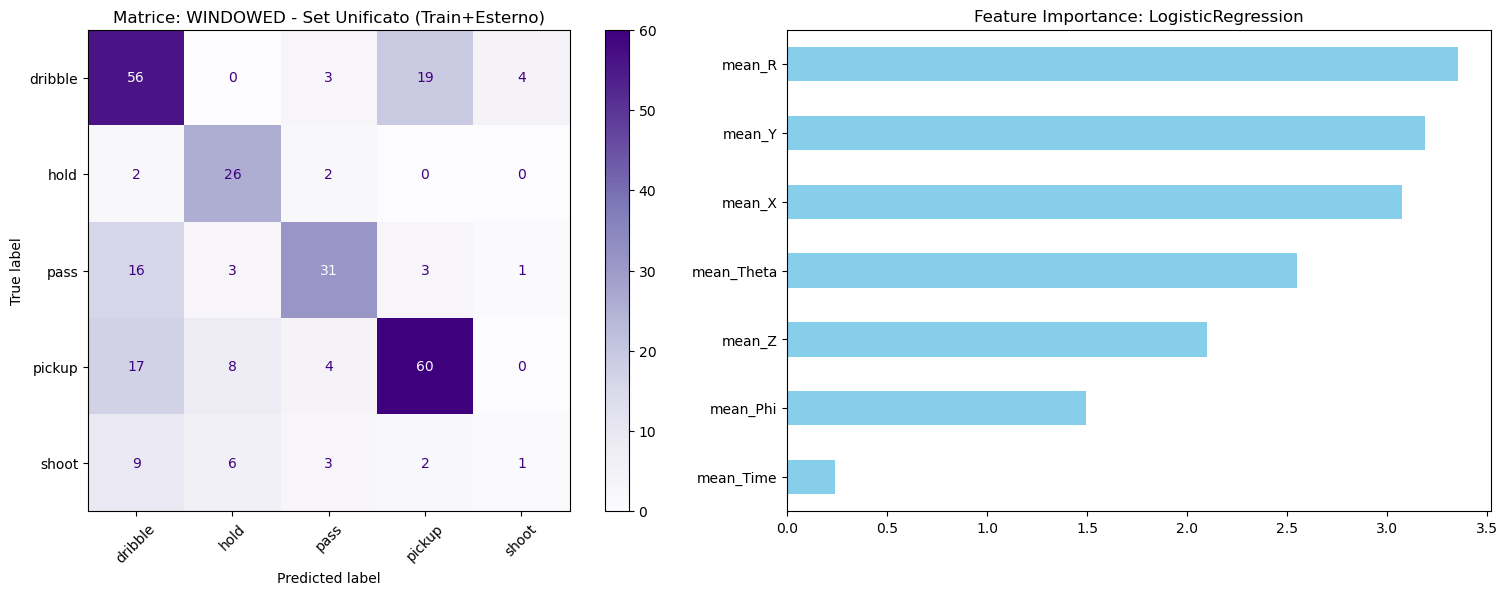

Ricerca parametri migliori per XGBoost...
Migliori Parametri (WINDOWED - Set Unificato (Train+Esterno)): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

========== XGBoost | WINDOWED - Set Unificato (Train+Esterno) ==========
              precision    recall  f1-score   support

     dribble       0.82      0.84      0.83        82
        hold       0.97      1.00      0.98        30
        pass       0.84      0.89      0.86        54
      pickup       0.88      0.89      0.88        89
       shoot       0.86      0.57      0.69        21

    accuracy                           0.86       276
   macro avg       0.87      0.84      0.85       276
weighted avg       0.86      0.86      0.86       276



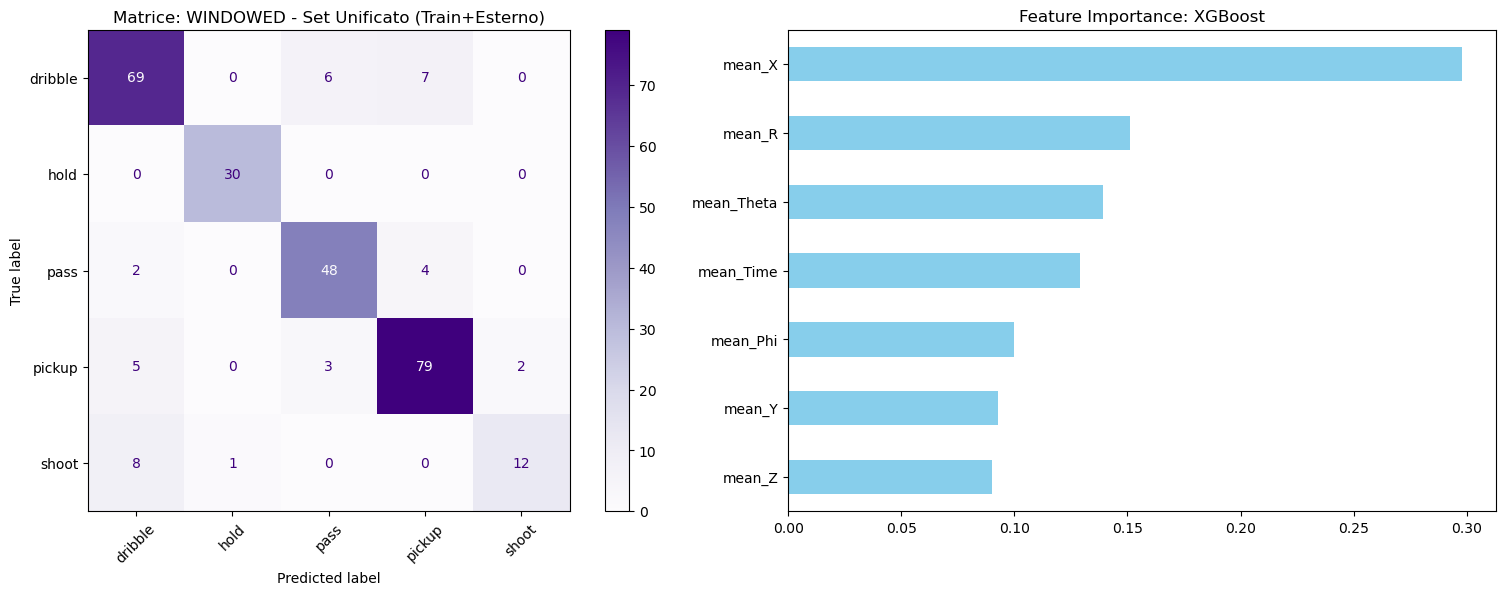

In [67]:
X_combined = pd.concat([X_w_full, X_w_ext], axis=0).reset_index(drop=True)
y_combined = pd.concat([y_w_full, y_w_ext], axis=0).reset_index(drop=True)

X_tr_w, X_te_w, y_tr_w, y_te_w = train_test_split(
    X_combined, 
    y_combined, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_combined
)

for name, model in models_dict.items():
    grid_params = params_dict.get(name)
    train_and_evaluate(
        name, model, 
        X_tr_w, y_tr_w, X_te_w, y_te_w, 
        "WINDOWED - Set Unificato (Train+Esterno)", 
        param_grid=grid_params, 
        cmap='Purples'
    )

#### Analisi dei risultati sul Set Unificato

L’integrazione dei dati di laboratorio e dei dati spontanei nel Set Unificato ha portato a un miglioramento complessivo delle prestazioni e, soprattutto, a una maggiore stabilità nel comportamento dei modelli sulle diverse classi di gesto.

- **Logistic Regression**: nonostante la natura lineare del modello, si osserva un beneficio evidente derivante dall’uso del dataset misto. L’accuratezza complessiva raggiunge il **63%**, con un **Macro F1-score pari a 0.55**. In particolare, la classe **hold** mostra un netto miglioramento, raggiungendo un **F1-score di 0.71**, riducendo in modo significativo il collasso verso la classe **pickup** osservato nei test precedenti. Anche **pickup** mantiene buone prestazioni (F1 = **0.69**), mentre **dribble** e **pass** risultano moderatamente separabili (F1 rispettivamente **0.62** e **0.64**).  
  Rimane invece critica la classe **shoot**, che presenta un **F1-score di 0.07**, con Precision pari a **0.17** e Recall estremamente basso (**0.05**), indicando che il gesto del tiro rimane difficilmente isolabile tramite una separazione lineare delle feature, anche in presenza di un dataset più vario. Nel complesso, questi risultati suggeriscono che la maggiore eterogeneità del dato migliora la robustezza del modello, pur senza risolverne i limiti strutturali.

- **XGBoost** conferma prestazioni nettamente superiori, raggiungendo un’**accuratezza dell’86%** e un **Macro F1-score di 0.85**. Tutte le classi principali risultano ben discriminate: **hold** raggiunge un **F1-score di 0.98**, **pickup** e **pass** rispettivamente **0.88** e **0.86**, mentre **dribble** mantiene un’elevata affidabilità (**F1 = 0.83**).  
  Un risultato particolarmente rilevante riguarda la classe **shoot**, che raggiunge un **F1-score di 0.69** con un Recall pari a **0.57**, indicando che l’inclusione di esempi spontanei nel training set consente al modello di apprendere una rappresentazione più generale e trasferibile del gesto. L’analisi delle feature più rilevanti evidenzia come le componenti legate all’orientamento e all’inclinazione del braccio rivestano un ruolo centrale nel processo decisionale, suggerendo che tali grandezze rappresentano segnali più stabili e discriminanti rispetto al solo profilo accelerometrico.

Nel complesso, i risultati mostrano come l’utilizzo di un Set Unificato permetta di ottenere modelli più robusti e meglio bilanciati tra le classi, riducendo il gap di generalizzazione osservato nei test esterni. Rimangono tuttavia alcune limitazioni legate allo sbilanciamento dei dati e alla presenza di acquisizioni spontanee provenienti da un singolo utente, che potrebbero introdurre bias residui nel modello.


In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_final_comparison(results_dict):
    df_res = pd.DataFrame(results_dict)
    
    # Suddivisione scenari
    df_raw = df_res[df_res['Scenario'].str.contains('RAW')].copy()
    df_win = df_res[df_res['Scenario'].str.contains('WINDOWED')].copy()
    df_uni = df_res[df_res['Scenario'].str.contains('Unificato')].copy()
    
    for df in [df_raw, df_win, df_uni]:
        df['Model_Display'] = df['Model'].apply(lambda x: x.replace('_Windowed', ''))
        # Definiamo il tipo di test per la legenda
        if 'Unificato' in df['Scenario'].iloc[0] if not df.empty else False:
            df['Test_Type'] = 'Split Unificato (Mix)'
        else:
            df['Test_Type'] = df['Scenario'].apply(lambda x: 'Interno' if 'Interno' in x else 'Esterno (Spontaneo)')

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 7), sharey=True)
    
    # Palette colori estesa
    pal = {
        'Interno': '#3498db', 
        'Esterno (Spontaneo)': '#e74c3c', 
        'Split Unificato (Mix)': '#9b59b6' # Viola per l'unificato
    }

    # 1. RAW DATA
    sns.barplot(data=df_raw, x='Model_Display', y='F1-Score', hue='Test_Type', ax=ax1, palette=pal, edgecolor='black')
    ax1.set_title('RAW DATA', fontsize=14, fontweight='bold')
    ax1.set_ylabel('F1-Score Macro')

    # 2. WINDOWED (Standard)
    sns.barplot(data=df_win, x='Model_Display', y='F1-Score', hue='Test_Type', ax=ax2, palette=pal, edgecolor='black')
    ax2.set_title('WINDOWED (50 Windows)', fontsize=14, fontweight='bold')

    # 3. UNIFICATO (Training con dati reali)
    sns.barplot(data=df_uni, x='Model_Display', y='F1-Score', hue='Test_Type', ax=ax3, palette=pal, edgecolor='black')
    ax3.set_title('WINDOWED UNIFICATO (Mix Train+Ext)', fontsize=14, fontweight='bold')

    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0, 1.2)
        ax.set_xlabel('Modelli')
        ax.legend(title='Validazione', loc='upper right')
        ax.grid(axis='y', linestyle=':', alpha=0.5)
        for p in ax.patches:
            h = p.get_height()
            if h > 0:
                ax.annotate(f'{h:.2f}', (p.get_x() + p.get_width()/2., h), 
                            ha='center', va='center', xytext=(0, 10), 
                            textcoords='offset points', fontsize=10, fontweight='bold')

    plt.suptitle('Evoluzione delle Performance: Dai Dati Raw all\'Unificazione del Dataset', fontsize=18, y=1.05)
    plt.tight_layout()
    plt.show()

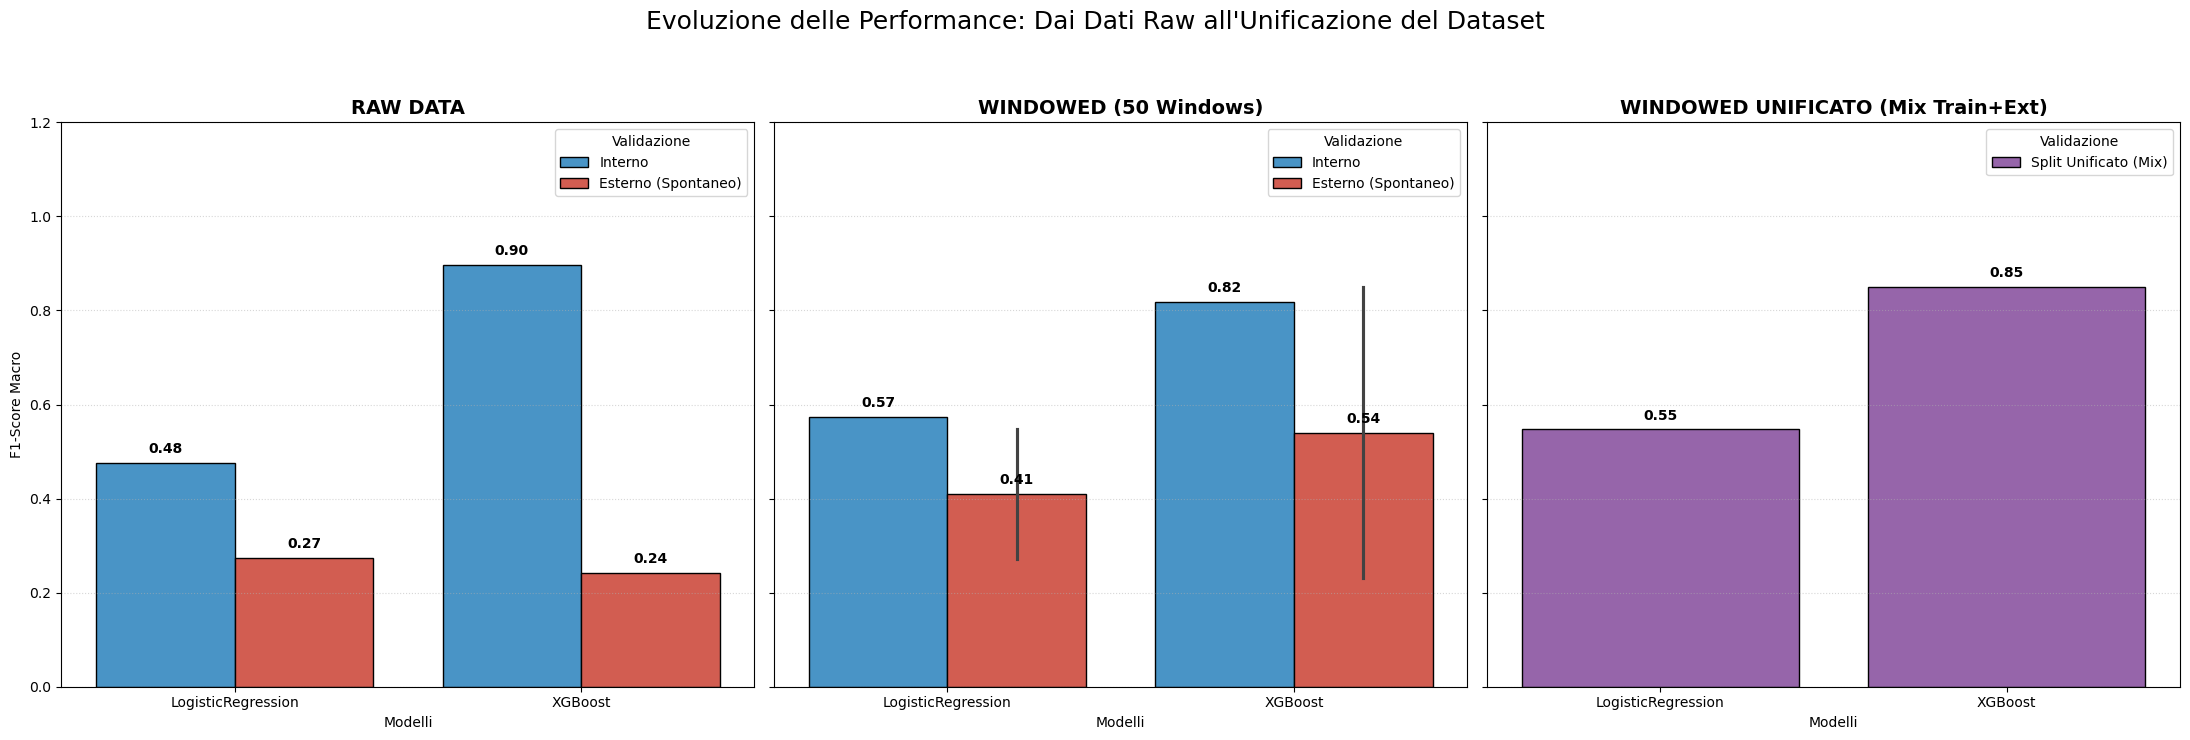

In [70]:
plot_final_comparison(results_history)

### Conclusione finale: dal segnale istantaneo alla rappresentazione del gesto

L’analisi comparativa delle performance evidenzia in modo chiaro come la qualità della rappresentazione del dato sia il fattore determinante per il successo del modello, più della complessità dell’algoritmo stesso.

I **dati RAW**, intesi come campioni istantanei del segnale, risultano fortemente rumorosi e privi di contesto temporale. In questo scenario, entrambi i modelli falliscono nel generalizzare, con prestazioni elevate solo sullo split interno e un crollo netto sul test esterno spontaneo. Il modello apprende pattern locali e transitori, che non rappresentano il gesto atletico nella sua interezza.

L’introduzione del **windowing (50 finestre)** segna un primo cambio di paradigma: il segnale viene trasformato da una sequenza di istanti indipendenti a una descrizione statistica del movimento. Questo passaggio riduce la variabilità istantanea e rende più stabili le feature, producendo un miglioramento consistente soprattutto nello split interno. Tuttavia, il gap di generalizzazione verso il dominio spontaneo rimane evidente, indicando che la sola segmentazione temporale non è sufficiente.

Il vero salto qualitativo emerge con il **dataset unificato (Mix Train + Esterno)**. L’inclusione di esempi spontanei nel training consente ai modelli di apprendere una rappresentazione più ampia e realistica del gesto cestistico. In questo scenario, le performance diventano più bilanciate tra le classi e più stabili, confermando che la copertura del dominio di acquisizione è un elemento chiave per la robustezza del sistema. Ricordando anche che però il modello è biased poichè l'aquisizione spontanea è di un solo utente.

In sintesi, i risultati mostrano che **il gesto non è contenuto nel singolo campione**, ma emerge dalla sua evoluzione temporale e dalla variabilità del contesto. Windowing e diversità del dato non sono semplici accorgimenti di preprocessing, ma passaggi necessari per passare da un modello da laboratorio a un sistema utilizzabile in condizioni reali.
